# Fine-Tuning StarCoder2-1B for **Python Chart Code Generation** Using LoRA on ChartGen-200K Dataset

# **Summary**

## **Complete Pipeline Overview (End-to-End)**

### Step 0 — Environment & Dependencies
Installing and importing required libraries, setting up Google Drive and filesystem, and loading Hugging Face authentication token for dataset access.

### Step 1 - Setting up Configurations
Defining model parameters, training hyperparameters, LoRA settings, and file paths for the entire pipeline.

### Step 2 - Loading Base Model
Loading the **StarCoder2-1B** model with its tokenizer from Hugging Face. Configuring the padding token by setting it to the EOS token if missing. Applying 8-bit quantization to reduce memory footprint while maintaining computation in half-precision. Enabling gradient checkpointing for memory efficiency during training. Preparing the model for quantized training by adjusting internal components. Resizing token embeddings to match the updated vocabulary size after tokenizer modifications.

### Step 3 - Loading and Applying LoRA (Low-Rank Adaptation)
Adding LoRA layers to the model's attention modules. Freezing the base model weights and training only the small LoRA adapters, which represent approximately 0.1% of total parameters. This dramatically reduces memory usage, training time, and storage requirements while maintaining model performance.

### Step 4 - Preparing the Dataset
Loading the **ChartGen-200K** dataset from cache or downloading from Hugging Face if not available. Filtering samples for quality by checking for valid plot commands, complete code structure, and matplotlib usage. Cleaning the code by removing variation comments. Formatting each example using a prompt template with Task, Data, Description, and Code sections. Tokenizing all samples with a maximum length of 2048 tokens. Splitting the dataset into 90% training and 10% test sets. Caching both cleaned and tokenized datasets to Google Drive for future runs.

### Step 5 - Executes the Dataset Preparation Function
Loading a subset of **2000 samples** from the prepared dataset and tokenizing them with a **2048 token maximum length**. Removing all unnecessary columns from the dataset, keeping only the six essential fields: **input_ids, attention_mask, labels, csv, summary, and code**. Exporting the cleaned dataset to Google Drive as a backup for future notebook sessions.

### Step 6 — Model Fine-Tuning
Configuring dynamic padding so each batch is padded only to its longest sequence rather than a fixed maximum length. Setting up training arguments including learning rate, batch size, and number of epochs. Enabling automatic checkpoint resumption to continue from the most recent checkpoint if training is interrupted. Initializing the Trainer with the model, datasets, and data collator, then executing the training process.

### Step 7 - Evaluation For Fine-Tuned Model and Base Model
Testing both the fine-tuned model and base model by generating predictions on sample inputs. Measuring core quality metrics including **syntax correctness** (valid Python parsing), **compilation success** (executable bytecode), and **execution success** (runs without errors and produces plots). Measuring image quality through **SSIM** (structural similarity on 0-1 scale) and **pixel similarity** (normalized pixel-wise comparison). Measuring **chart completeness** by checking for plot calls, axis labels, titles, legends, and gridlines. Calculating an **overall weighted score** combining 40% execution success, 30% image similarity, 20% chart elements, and 10% syntax correctness to provide a single performance metric between 0-100%.

### Step 8 — Saves Outputs for Both Models
Exporting evaluation metrics and saving comprehensive summary reports documenting the performance of both the fine-tuned and base models.

### (Optional) Appendix
- Code for cleaning GPU RAM and freeing memory resources after training and evaluation.
- Code for uploding the final model to HuggingFace

# **0. Environment & Dependencies**
- Installing and importing libraries
- Setting up Drive/Filesystem
- Loading the Hugging Face token to access dataset

In [ ]:
!pip install transformers accelerate peft bitsandbytes datasets torch torchao python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 16.1 MB/s eta 0:00:00


In [ ]:
import torch
import os
import json
from pathlib import Path
from datasets import load_dataset, load_from_disk
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    TaskType
)
from peft import PeftModel
import bitsandbytes as bnb
from tqdm import tqdm
import numpy as np
from transformers import BitsAndBytesConfig

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from dotenv import load_dotenv
import os

# Set path to your .env file in Drive
env_path = "/content/drive/MyDrive/Colab Notebooks/colab_access_token.env"

load_dotenv(env_path)  # Loads variables from your .env file

# Access your Hugging Face token stored in .env as HF_HUB_TOKEN
hf_token = os.getenv("HF_HUB_TOKEN")

#print("Hugging Face Token:", hf_token)  # For debug, remove in production

In [ ]:
from huggingface_hub import login
login(hf_token)

# **1. Setting up Configurations**

In [ ]:
MODEL_NAME = "bigcode/starcoderbase-1b"
DATASET_NAME = "SD122025/ChartGen-200K"
OUTPUT_DIR = "./starcoder2-chartgen-lora"
DATASET_CACHE_DIR = "./dataset_cache"
MODEL_CACHE_DIR = "./model_cache"


LORA_CONFIG = {
    "r": 16,
    "lora_alpha": 32,
    "target_modules": [
        "c_attn",              # Query, Key, Value
        "c_proj",              # Attention output
        "c_fc",                # MLP layer 1
        "c_proj"               # MLP layer 2 (if different name)
    ],
    "lora_dropout": 0.1,
    "bias": "none",
    "task_type": TaskType.CAUSAL_LM
}

TRAINING_CONFIG = {
    "output_dir": OUTPUT_DIR,
    "num_train_epochs": 3,
    "per_device_train_batch_size": 1,
    "gradient_accumulation_steps": 8,  # Effective batch = 8
    "learning_rate": 1e-4,      # ← Decreased from 2e-4 (more stable)
    "warmup_steps": 500,        # ← Increased from 100 (smoother start)

    # Logging
    "logging_steps": 100,
    "logging_first_step": True,  # ← NEW: Log from step 1

    # Evaluation
    #"eval_strategy": "steps",
    #"eval_steps": 100,
    #"per_device_eval_batch_size": 1,

    # Saving
    "save_steps": 200,
    "save_total_limit": 3,      # ← Increased from 2
    #"load_best_model_at_end": True,  # ← NEW: Use best checkpoint
    #"metric_for_best_model": "eval_loss",  # ← NEW: Track best

    # Optimization
    "fp16": True,
    "optim": "paged_adamw_8bit",
    "gradient_checkpointing": True,
    "weight_decay": 0.01,       # ← NEW: L2 regularization
    "max_grad_norm": 1.0,       # ← NEW: Gradient clipping

    # Logging
    "report_to": "tensorboard",  # ← Changed from "none"
    "logging_dir": "./logs",     # ← NEW: Save logs
}

# **2. Loading Base Model**
- **Determines Whether to Use a Cache Directory**:
So that future runs load the model instantly without redownloading or if no cache the model is downloaded fresh each time.
- **Loads the Tokenizer**:
The tokenizer contains the vocabulary and rules that convert text into model-readable tokens. Because StarCoder2 uses custom logic, the function allows the tokenizer to execute code provided in its repository.
- **Ensures a Valid Padding Token Exists**:
StarCoder2 does not define a padding token. The function checks for this and assigns the end-of-sequence token as the padding token if necessary. It also explicitly sets padding to occur on the right side.
- **Prepares Quantization Settings for Efficient Loading and Loads the Model Using 8-Bit Quantization**:
Before loading the model, the function defines settings for 8-bit quantization. This quantization mode reduces the memory footprint by storing model weights in 8-bit precision while still computing intermediate results in half-precision. The StarCoder2-1B model is then loaded using the quantization settings.
- **Enables Gradient Checkpointing**:
This reduces memory usage during training by recomputing certain intermediate values rather than storing them.
- **Prepares the Model for 8-bit Training**:
The model is prepared for low-precision training using routines that adjust internal components for quantized fine-tuning. This includes updating layer norms and other structures so that gradients behave correctly.
- **Adjusts the Model's Embedding Layer**:
Because the tokenizer has been modified (by adding a padding token), the embedding matrix in the model must be resized to match the new vocabulary size.
- **Returns the Model and Tokenizer**:
Finally, the fully configured model and tokenizer are returned so they can be used for inference or fine-tuning elsewhere in the notebook.

In [ ]:
def load_model_and_tokenizer(use_cache=True):
    """
    Load StarCoder2-1B model with proper tokenizer configuration
    """
    cache_dir = MODEL_CACHE_DIR if use_cache else None

    print("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME,
        cache_dir=cache_dir,
        trust_remote_code=True  # Important for StarCoder2
    )

    # CRITICAL: Set padding token properly
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id

    tokenizer.padding_side = "right"

    print(f"Tokenizer vocab size: {len(tokenizer)}")
    print(f"Tokenizer pad token: {tokenizer.pad_token}")
    print(f"Tokenizer eos token: {tokenizer.eos_token}")

    print("\nLoading model with 8-bit quantization...")

    # Configure 8-bit quantization
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_compute_dtype=torch.float16,
        bnb_8bit_use_double_quant=True,
    )

    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        cache_dir=cache_dir,
        quantization_config=bnb_config,
        device_map="auto",
        torch_dtype=torch.float16,
        trust_remote_code=True  # Important for StarCoder2
    )

    # Enable gradient checkpointing to save memory
    model.gradient_checkpointing_enable()

    # Prepare model for k-bit training
    model = prepare_model_for_kbit_training(model)

    # Resize token embeddings if needed
    model.resize_token_embeddings(len(tokenizer))

    if use_cache:
        print(f"✓ Model cached in: {MODEL_CACHE_DIR}")

    return model, tokenizer

In [ ]:
model, tokenizer = load_model_and_tokenizer()

Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/777k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/442k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/532 [00:00<?, ?B/s]

Tokenizer vocab size: 49152
Tokenizer pad token: <|endoftext|>
Tokenizer eos token: <|endoftext|>

Loading model with 8-bit quantization...


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

✓ Model cached in: ./model_cache


# **3. Loading and Applying LoRA**
LoRA (Low-Rank Adaptation) is a memory-efficient fine-tuning technique. Instead of training all model parameters, LoRA adds small trainable adapter layers to specific parts of the model (attention layers). This means only a tiny fraction of parameters (in our case - 0.1%) need to be trained, reducing memory usage, training time, and storage requirements.

In [ ]:
def apply_lora(model):
    """
    Apply LoRA (Low-Rank Adaptation) to the model

    LoRA adds small trainable matrices to existing layers instead of
    fine-tuning all parameters. This dramatically reduces:
    - Memory usage (train only ~0.1% of parameters)
    - Training time
    - Storage (save only adapter weights, not full model)
    """

    print("Applying LoRA configuration...")
    lora_config = LoraConfig(**LORA_CONFIG)
    model = get_peft_model(model, lora_config)

    # Print trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())

    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable %: {100 * trainable_params / total_params:.2f}%")

    return model

In [ ]:
model = apply_lora(model)

Applying LoRA configuration...
Trainable parameters: 11,108,352
Total parameters: 1,148,315,648
Trainable %: 0.97%


# **4. Preparing the Dataset (With Cleaning and Filtering)**
- **Loads datset**:
Attempts to load a cleaned dataset from Google Drive or downloads and processes the raw dataset from HuggingFace if nothing is found.
- **Dataset Cleaning**:
When building from HugginFace, filters samples for quality (checking for proper plot commands, code completeness, and matplotlib usage), and removes variation comments from the ground-truth code.
- **Subset Selection**:
The function can works with either the full dataset or a specified number of samples.
- **Tokenization**:
It converts the text data into token IDs that the model can process. Each example is formatted using a specific prompt template (with Task, Data, Description, and Code sections), then tokenized with truncation to a maximum length. The labels are set to be identical to the input IDs for causal language modeling.
- **Train-Test Split**:
The tokenized dataset is split into 90% training and 10% test data for evaluation purposes.
- **Multi-Level Caching**:
The function exports to Drive both the cleaned dataset and the tokenized dataset at different stages.

In [ ]:
def format_prompt(csv: str, summary: str, code: str) -> str:
    """Format the training prompt"""
    return f"""### Task: Generate Python chart code

### Data:
{csv}

### Description:
{summary}

### Code:
{code}"""


def clean_code(example):
    """Remove # Variation comments and clean up code"""
    code = example['code']
    lines = code.split('\n')
    # Remove lines starting with # Variation
    cleaned_lines = [l for l in lines if not l.strip().startswith('# Variation:')]
    example['code'] = '\n'.join(cleaned_lines).strip()
    return example


def is_good_sample(example):
    """Check if sample is high quality"""
    code = example['code']

    # Must have a plot call
    has_plot = any(p in code for p in ['plt.plot', 'plt.bar', 'plt.scatter',
                                       'plt.pie', 'plt.hist', 'plt.boxplot',
                                       'plt.imshow', 'plt.contour', 'plt.fill',
                                       'plt.stem', 'plt.step', 'plt.errorbar'])

    # Must be reasonably complete (not truncated)
    is_complete = len(code) > 200 and code.count('\n') > 5

    # Prefer matplotlib for consistency
    uses_matplotlib = 'matplotlib' in code or 'plt.' in code

    return has_plot and is_complete and uses_matplotlib


def export_clean_dataset_to_drive():
    """Export clean dataset to Google Drive for safekeeping"""
    from google.colab import drive

    # Mount Drive if not already mounted
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    clean_cache_path = f"{DATASET_CACHE_DIR}_clean"
    drive_export_path = "/content/drive/MyDrive/ChartGen_Clean_Dataset"

    if os.path.exists(clean_cache_path):
        print(f"Exporting clean dataset to Google Drive...")
        print(f"Source: {clean_cache_path}")
        print(f"Destination: {drive_export_path}")

        import shutil
        shutil.copytree(clean_cache_path, drive_export_path, dirs_exist_ok=True)

        print(f"✓ Dataset exported to Drive")
        print(f"  You can now access it from any notebook!")
    else:
        print(f"❌ Clean cache not found at {clean_cache_path}")
        print(f"   Run prepare_dataset() first to create it.")


def load_clean_dataset_from_drive():
    """Load clean dataset from Google Drive if it exists"""
    from google.colab import drive

    # Mount Drive if not already mounted
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    drive_dataset_path = "/content/drive/MyDrive/ChartGen_Clean_Dataset"

    if os.path.exists(drive_dataset_path):
        print(f"Loading clean dataset from Google Drive...")
        print(f"Path: {drive_dataset_path}")
        try:
            from datasets import load_from_disk
            dataset = load_from_disk(drive_dataset_path)
            print(f"✓ Loaded clean dataset from Drive: {len(dataset)} samples")
            return dataset
        except Exception as e:
            print(f"⚠️ Failed to load from Drive: {e}")
            return None
    else:
        print(f"Clean dataset not found in Drive at: {drive_dataset_path}")
        return None


def prepare_dataset(tokenizer, max_length=2048, num_samples=None, use_cache=True, force_reload=False):
    """
    Load and preprocess ChartGen-200K dataset

    Loading priority:
    1. Tokenized cache (fastest)
    2. Google Drive exported dataset (if exists)
    3. Local clean cache
    4. Download and build from HuggingFace
    """

    # Paths
    clean_cache_path = f"{DATASET_CACHE_DIR}_clean"

    # Create tokenized cache path based on size
    if num_samples is None:
        tokenized_cache_path = f"{DATASET_CACHE_DIR}_tokenized_full"
        cache_size_key = "full"
    else:
        tokenized_cache_path = f"{DATASET_CACHE_DIR}_tokenized_{num_samples}"
        cache_size_key = num_samples

    # STEP 1: Try to load tokenized cache (fastest)
    if use_cache and os.path.exists(tokenized_cache_path) and not force_reload:
        print(f"Loading cached tokenized dataset from {tokenized_cache_path}...")
        try:
            cached_dataset = load_from_disk(tokenized_cache_path)

            if 'train' in cached_dataset and 'test' in cached_dataset:
                sample = cached_dataset["train"][0]
                if 'input_ids' in sample and 'labels' in sample:
                    decoded = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)
                    if "### Task:" in decoded or "### Code:" in decoded:
                        print(f"✓ Loaded tokenized cache: {len(cached_dataset['train'])} train, {len(cached_dataset['test'])} test")
                        return cached_dataset["train"], cached_dataset["test"]

            print("⚠️ Tokenized cache invalid, will regenerate...")

        except Exception as e:
            print(f"⚠️ Failed to load tokenized cache: {e}")

    # STEP 2A: Try to load from Google Drive
    dataset = None
    if not force_reload:
        dataset = load_clean_dataset_from_drive()

    # STEP 2B: Try local clean cache if Drive didn't work
    if dataset is None and use_cache and os.path.exists(clean_cache_path) and not force_reload:
        print(f"Loading clean dataset from local cache {clean_cache_path}...")
        try:
            dataset = load_from_disk(clean_cache_path)
            print(f"✓ Loaded clean dataset from local cache: {len(dataset)} samples")
        except Exception as e:
            print(f"⚠️ Failed to load local clean cache: {e}")
            print("Will rebuild clean dataset...")
            dataset = None

    # STEP 3: Build clean dataset if not loaded
    if dataset is None:
        print("\n" + "="*80)
        print("BUILDING CLEAN DATASET (this happens once)")
        print("="*80)

        # Download from HuggingFace
        print("\n1. Downloading dataset from HuggingFace...")
        raw_dataset = load_dataset(DATASET_NAME, split="train")
        print(f"   Downloaded: {len(raw_dataset)} samples")

        # Filter for quality
        print("\n2. Filtering for quality...")
        print(f"   Original size: {len(raw_dataset)}")
        dataset = raw_dataset.filter(is_good_sample, desc="Filtering")
        kept_pct = len(dataset) / len(raw_dataset) * 100
        print(f"   Filtered size: {len(dataset)} ({kept_pct:.1f}% kept)")

        # Clean code
        print("\n3. Cleaning code (removing variation comments)...")
        dataset = dataset.map(clean_code, desc="Cleaning")
        print(f"   ✓ Cleaned {len(dataset)} samples")

        # Cache the clean dataset locally
        if use_cache:
            print(f"\n4. Caching clean dataset to {clean_cache_path}...")
            os.makedirs(clean_cache_path, exist_ok=True)
            dataset.save_to_disk(clean_cache_path)
            print(f"   ✓ Clean dataset cached locally")

        print("\n" + "="*80)
        print(f"CLEAN DATASET READY: {len(dataset)} high-quality samples")
        print("="*80 + "\n")

    # STEP 4: Select subset
    if num_samples is not None:
        actual_samples = min(num_samples, len(dataset))
        dataset = dataset.select(range(actual_samples))
        print(f"Using subset: {actual_samples} samples")
    else:
        print(f"Using full clean dataset: {len(dataset)} samples")

    # STEP 5: Tokenize
    def tokenize_function(examples):
        """Tokenize with proper error checking"""
        texts = []
        for csv, summ, code in zip(examples["csv"], examples["summary"], examples["code"]):
            text = format_prompt(csv, summ, code)  # ← format_prompt used here!
            texts.append(text)

        tokenized = tokenizer(
            texts,
            truncation=True,
            max_length=max_length,
            padding=False,
            return_tensors=None,
            add_special_tokens=True
        )

        tokenized["labels"] = [ids[:] for ids in tokenized["input_ids"]]

        return tokenized

    print("\nTokenizing dataset...")
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        batch_size=100,
        desc="Tokenizing",
        num_proc=1
    )

    # Verify tokenization
    print("\nVerifying tokenization...")
    sample = tokenized_dataset[0]
    decoded = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)
    print(f"Sample decoded text (first 200 chars):\n{decoded[:200]}...")

    if "### Task:" not in decoded and "### Code:" not in decoded:
        print("❌ ERROR: Tokenization failed!")
        raise ValueError("Tokenization produced invalid output")

    print("✓ Tokenization verification passed")

    # STEP 6: Split
    split_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)

    # STEP 7: Cache tokenized dataset
    if use_cache:
        print(f"\nCaching tokenized dataset to {tokenized_cache_path}...")
        os.makedirs(tokenized_cache_path, exist_ok=True)
        split_dataset.save_to_disk(tokenized_cache_path)
        print(f"✓ Tokenized dataset cached (size: {cache_size_key})")

    return split_dataset["train"], split_dataset["test"]

# **5. Building the Dataset (and OPTIONAL: saving)**
- Loads 2000 samples from the ChartGen dataset, tokenizes them with a maximum sequence length of 2048 tokens, and splits them into training and test sets.
- Removes all unnecessary columns and keeps only six specific ones: the three tensor fields required for training (input_ids, attention_mask, labels) plus the three original text fields (csv, summary, code)
- The commented-out line suggests that after the first successful run, you should export the cleaned dataset to Google Drive as a backup.

In [ ]:
# Load dataset WITH all fields
train_dataset_full, eval_dataset_full = prepare_dataset(
    tokenizer,
    max_length=2048,
    num_samples=2000,
)

print(f"Full dataset columns: {train_dataset_full.column_names}")

# Create training version (tensor fields + csv, summary, code)
columns_to_keep = [
    'input_ids',
    'attention_mask',
    'labels',
    'csv',
    'summary',
    'code'
]

train_dataset_clean = train_dataset_full.remove_columns(
    [col for col in train_dataset_full.column_names
     if col not in columns_to_keep]
)

eval_dataset_clean = eval_dataset_full.remove_columns(
    [col for col in eval_dataset_full.column_names
     if col not in columns_to_keep]
)

print(f"Clean dataset columns: {train_dataset_clean.column_names}")
# Should show: ['input_ids', 'attention_mask', 'labels', 'csv', 'summary', 'code']

Loading clean dataset from Google Drive...
Path: /content/drive/MyDrive/ChartGen_Clean_Dataset
✓ Loaded clean dataset from Drive: 70442 samples
Using subset: 2000 samples

Tokenizing dataset...


Tokenizing:   0%|          | 0/2000 [00:00<?, ? examples/s]


Verifying tokenization...
Sample decoded text (first 200 chars):
### Task: Generate Python chart code

### Data:
Language,Popularity
Python,69.8
Java,62.6
C++,57.3
JavaScript,49.6
C#,46.1
Go,29.6
Ruby,2.7
Swift,2.3
Kotlin,1.9
Rust,1.5

### Description:
The chart is...
✓ Tokenization verification passed

Caching tokenized dataset to ./dataset_cache_tokenized_2000...


Saving the dataset (0/1 shards):   0%|          | 0/1800 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

✓ Tokenized dataset cached (size: 2000)
Full dataset columns: ['id', 'code', 'image', 'image_path', 'summary', 'csv', 'doctags', 'question_answers', 'input_ids', 'attention_mask', 'labels']
Clean dataset columns: ['code', 'summary', 'csv', 'input_ids', 'attention_mask', 'labels']


**ADD WHEN RUNNING FOR THE FIRST TIME (TO SAVE CLEAN DATSET)**

In [ ]:
# ADD WHEN RUNNING FOR THE FIRST TIME
#export_clean_dataset_to_drive()

# **6. Model Fine-Tuning**

- **Checkpoint Resumption**:
Checks if there are existing training checkpoints in the output directory and automatically resumes from the most recent one if requested to continue interrupted training runs.
- **Dynamic Padding**:
Initializes a data collator that performs dynamic padding - padding each batch only to the length of the longest sequence in that specific batch rather than a fixed maximum length.

In [ ]:
def compute_metrics(eval_pred):
    return {}  # Placeholder; detailed metrics computed after training

In [ ]:
def train_model(model, tokenizer, train_dataset, eval_dataset, resume_from_checkpoint=None):

    # Check for existing checkpoints
    if resume_from_checkpoint is True:
        checkpoints = [d for d in os.listdir(OUTPUT_DIR) if d.startswith("checkpoint-")] if os.path.exists(OUTPUT_DIR) else []
        resume_from_checkpoint = os.path.join(OUTPUT_DIR, max
        (checkpoints)) if checkpoints else None

    # Ensure tokenizer has pad_token set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id

    # Training arguments
    training_args = TrainingArguments(**TRAINING_CONFIG)

    # Data collator with explicit padding
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False,
        # This will dynamically pad to the longest sequence in each batch
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train(resume_from_checkpoint=resume_from_checkpoint)

    return trainer

In [ ]:
trainer = train_model(model, tokenizer, train_dataset_clean, eval_dataset_clean)

/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
1,0.936100
100,0.881600
200,0.534200
300,0.433500
400,0.397900
500,0.363200
600,0.345500


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


# **7. Evaluation For Fine-Tuned Model and Base Model**
Evaluation For Fine-Tuned Model and Base Model
1) Evaluation:

**Core Quality Metrics**:  
- *Syntax Correctness*: Whether the generated code is valid Python that can be parsed without syntax errors
- *Compilation Success*: Whether the code can be compiled into executable bytecode
- *Execution Success*: Whether the code actually runs without runtime errors and produces a plot

**Image Quality Metrics**:  
- *SSIM* (Structural Similarity Index): Measures how structurally similar the generated plot is to the reference plot on a 0-1 scale, where 1 means identical structure
- *Pixel Similarity*: Measures how closely the pixel values match between generated and reference images (1 minus normalized mean squared error)

**Chart Completeness Metrics**:
- *Has Plot Call*: Whether the code contains actual plotting functions like plt.plot, plt.bar, plt.scatter, etc.
- *Has Labels*: Whether the code includes x-axis and y-axis labels
- *Has Title*: Whether a chart title is present
- *Has Legend*: Whether a legend is included
- *Has Grid*: Whether gridlines are added

**Overall Score**:
A weighted composite score combining:
- 40% execution success (most important - does it work?)
- 30% image similarity (does it look right?)
- 20% chart elements (is it complete?)
- 10% syntax correctness (is the code valid?).

This provides a single performance number between 0-100%.

2) Viewing predictions on 2 samples

**7.1 EVALUATION FOR FINE-TUNED MODEL**

**Model loading**

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

MODEL_NAME = "dormosol/starcoderbase-chartgen-lora"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/874 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/986 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

**Defining Evaluation for Fine-Tuned Model**

In [ ]:
# COMPLETE EVALUATION SETUP

import matplotlib.pyplot as plt
import io
from PIL import Image
import numpy as np
from collections import defaultdict
import ast
import torch
from datasets import load_from_disk
from tqdm import tqdm
from transformers import StoppingCriteria, StoppingCriteriaList

# STOPPING CRITERIA CLASS

class StopOnString(StoppingCriteria):
    """Stop generation when specific strings are encountered"""
    def __init__(self, tokenizer, stop_strings):
        self.tokenizer = tokenizer
        self.stop_token_sequences = []
        for s in stop_strings:
            tokens = tokenizer.encode(s, add_special_tokens=False)
            if len(tokens) > 0:
                self.stop_token_sequences.append(tokens)

    def __call__(self, input_ids, scores, **kwargs):
        for stop_seq in self.stop_token_sequences:
            if len(input_ids[0]) >= len(stop_seq):
                last_tokens = input_ids[0][-len(stop_seq):].tolist()
                if last_tokens == stop_seq:
                    return True
        return False

# HELPER FUNCTIONS

def extract_code_clean(generated_text):
    """Extract only Python code, stop at explanations"""
    if "### Code:" in generated_text:
        code = generated_text.split("### Code:")[-1]
    else:
        code = generated_text

    stop_markers = [
        "### Output:", "### Explanation:", "### Note:",
        "### Example:", "### Result:", "\n\n### ",
    ]

    for marker in stop_markers:
        if marker in code:
            code = code.split(marker)[0]

    return code.strip()

def check_syntax(code):
    """Check if code has valid Python syntax"""
    try:
        ast.parse(code)
        return True
    except SyntaxError:
        return False

def check_compilation(code):
    """Check if code compiles"""
    try:
        compile(code, '<string>', 'exec')
        return True
    except:
        return False

def check_chart_components(code):
    """Check for common chart elements in code"""
    return {
        'has_plot_call': any(x in code for x in ['plt.plot', 'plt.bar', 'plt.scatter', 'plt.pie', 'plt.hist', 'plt.line']),
        'has_xlabel': 'xlabel' in code,
        'has_ylabel': 'ylabel' in code,
        'has_title': 'title' in code,
        'has_legend': 'legend' in code,
        'has_grid': 'grid' in code,
    }

def execute_and_capture_plot(code, timeout=5):
    """Execute code and capture the generated plot as an image"""
    try:
        plt.close('all')

        namespace = {
            '__builtins__': __builtins__,
            'plt': plt,
            'pd': __import__('pandas'),
            'np': __import__('numpy'),
            'matplotlib': __import__('matplotlib'),
            'StringIO': __import__('io').StringIO,
            'io': __import__('io'),
        }

        exec(code, namespace)
        fig = plt.gcf()
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)
        image = Image.open(buf)
        image_array = np.array(image.convert('RGB'))
        plt.close('all')

        return True, image_array, None

    except Exception as e:
        plt.close('all')
        return False, None, str(e)

def compare_images(img1, img2):
    """Compare two images using SSIM and pixel similarity"""
    try:
        from skimage.metrics import structural_similarity as ssim
        from skimage.metrics import peak_signal_noise_ratio as psnr
        HAS_SKIMAGE = True
    except ImportError:
        HAS_SKIMAGE = False

    try:
        if img1.shape != img2.shape:
            if HAS_SKIMAGE:
                from skimage.transform import resize
                img2 = resize(img2, img1.shape, anti_aliasing=True)
                img2 = (img2 * 255).astype(np.uint8)
            else:
                return None

        if HAS_SKIMAGE:
            from skimage.color import rgb2gray
            img1_gray = rgb2gray(img1) if len(img1.shape) == 3 else img1
            img2_gray = rgb2gray(img2) if len(img2.shape) == 3 else img2
            ssim_score = ssim(img1_gray, img2_gray, data_range=1.0)
            psnr_score = psnr(img1, img2, data_range=255)
        else:
            ssim_score = 0
            psnr_score = 0

        mse = np.mean((img1.astype(float) - img2.astype(float)) ** 2)
        normalized_mse = mse / (255 ** 2)

        return {
            'ssim': ssim_score if HAS_SKIMAGE else 1 - normalized_mse,
            'psnr': psnr_score,
            'mse': mse,
            'normalized_mse': normalized_mse,
            'pixel_similarity': 1 - normalized_mse
        }

    except Exception as e:
        print(f"Image comparison error: {e}")
        return None

# EVALUATION FUNCTION

def evaluate_without_visualization_fixed(
    model,
    tokenizer,
    dataset_cache_dir,
    num_samples_eval=50,
    num_samples_dataset=2000,
    max_new_tokens=512,
    compare_with_ground_truth=True
):
    """Fixed evaluation with correct dataset split and ground truth comparison"""

    print(f"\n{'='*80}")
    print(f"🚀 STREAMLINED EVALUATION (FIXED VERSION)")
    print(f"{'='*80}\n")

    clean_cache_path = dataset_cache_dir
    clean_dataset = load_from_disk(clean_cache_path)
    print(f"Loaded full dataset: {len(clean_dataset)} samples")

    if num_samples_dataset is not None:
        actual_samples = min(num_samples_dataset, len(clean_dataset))
        clean_dataset = clean_dataset.select(range(actual_samples))
        print(f"✓ Selected subset: {actual_samples} samples (matching training)")
    else:
        print(f"✓ Using full dataset: {len(clean_dataset)} samples")

    split_dataset = clean_dataset.train_test_split(test_size=0.1, seed=42)
    eval_dataset = split_dataset["test"]
    print(f"✓ Test split: {len(eval_dataset)} samples")

    eval_subset = eval_dataset.select(range(min(num_samples_eval, len(eval_dataset))))
    print(f"✓ Evaluating: {len(eval_subset)} samples\n")

    results = defaultdict(list)
    failed_samples = []

    stop_strings = ["###", "\n\n\n", "# Output", "# Explanation", "# Note"]
    stopping_criteria = StoppingCriteriaList([
        StopOnString(tokenizer, stop_strings)
    ])
    print("✓ Stopping criteria created\n")

    for idx, sample in enumerate(tqdm(eval_subset, desc="Evaluating")):
        try:
            csv_data = sample['csv']
            summary = sample['summary']
            ground_truth_code = sample.get('code', '')

            reference_image = None
            if compare_with_ground_truth and ground_truth_code:
                ref_success, reference_image, ref_error = execute_and_capture_plot(ground_truth_code)
                if not ref_success:
                    reference_image = None

            prompt = f"""### Task: Generate Python chart code

### Data:
{csv_data}

### Description:
{summary}

### Code:
"""

            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(model.device)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    temperature=0.3,
                    do_sample=True,
                    top_p=0.9,
                    stopping_criteria=stopping_criteria,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.pad_token_id,
                    early_stopping=True,
                )

            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            generated_code = extract_code_clean(generated_text)

            syntax_valid = check_syntax(generated_code)
            compiles = check_compilation(generated_code)
            gen_success, gen_image, gen_error = execute_and_capture_plot(generated_code)

            results['syntax_correctness'].append(int(syntax_valid))
            results['compilation_success'].append(int(compiles))
            results['execution_success'].append(int(gen_success))

            if gen_success and gen_image is not None and reference_image is not None:
                img_metrics = compare_images(reference_image, gen_image)
                if img_metrics:
                    results['image_ssim'].append(img_metrics['ssim'])
                    results['pixel_similarity'].append(img_metrics['pixel_similarity'])
                    results['psnr'].append(img_metrics.get('psnr', 0))

            components = check_chart_components(generated_code)
            for comp_name, comp_value in components.items():
                results[comp_name].append(int(comp_value))

            if not gen_success:
                failed_samples.append({
                    'idx': idx,
                    'error': gen_error if gen_error else 'syntax',
                    'code': generated_code[:200]
                })

        except Exception as e:
            print(f"\n⚠️ Error on sample {idx}: {e}")
            for key in ['syntax_correctness', 'compilation_success', 'execution_success']:
                results[key].append(0)
            for comp in ['has_plot_call', 'has_xlabel', 'has_ylabel', 'has_title', 'has_legend', 'has_grid']:
                results[comp].append(0)

    final_metrics = {k: np.mean(v) for k, v in results.items() if v}
    final_metrics['samples_evaluated'] = len(eval_subset)
    final_metrics['num_failed'] = len(failed_samples)

    if 'image_ssim' in results:
        final_metrics['num_image_comparisons'] = len(results['image_ssim'])

    return final_metrics, failed_samples

def print_simple_report(metrics, failed_samples):
    """Quick metrics report"""
    print("📊 EVALUATION METRICS")

    print(f"\n✓ CORE METRICS:")
    print(f"  Syntax Valid:      {metrics.get('syntax_correctness', 0):.1%}")
    print(f"  Compiles:          {metrics.get('compilation_success', 0):.1%}")
    print(f"  Executes:          {metrics.get('execution_success', 0):.1%}")

    if metrics.get('image_ssim', 0) > 0:
        print(f"\n📊 IMAGE QUALITY:")
        print(f"  SSIM:              {metrics['image_ssim']:.3f} (0-1, higher=better)")
        print(f"  Pixel Similarity:  {metrics.get('pixel_similarity', 0):.1%}")
        if metrics.get('psnr', 0) > 0:
            print(f"  PSNR:              {metrics.get('psnr', 0):.2f} dB")

    print(f"\n📈 CHART ELEMENTS:")
    print(f"  Has Plot:          {metrics.get('has_plot_call', 0):.1%}")
    print(f"  Has Labels:        {(metrics.get('has_xlabel', 0) + metrics.get('has_ylabel', 0))/2:.1%}")
    print(f"  Has Title:         {metrics.get('has_title', 0):.1%}")

    score = (
        metrics.get('execution_success', 0) * 0.40 +
        metrics.get('image_ssim', 0) * 0.30 +
        metrics.get('has_plot_call', 0) * 0.20 +
        metrics.get('syntax_correctness', 0) * 0.10
    )

    print(f"\n⭐ OVERALL SCORE: {score:.1%}")
    print(f"   Samples: {int(metrics['samples_evaluated'])}")
    print(f"   Failed: {metrics['num_failed']}")
    if metrics.get('num_image_comparisons'):
        print(f"   Image Comparisons: {int(metrics['num_image_comparisons'])}")

    if len(failed_samples) > 0:
        print(f"\n📋 SAMPLE FAILURES (first 3):")
        for i, fail in enumerate(failed_samples[:3]):
            print(f"\n  {i+1}. Sample {fail['idx']}:")
            print(f"     Error: {fail['error']}")
            print(f"     Code: {fail['code'][:100]}...")

print("✓ All evaluation functions loaded successfully!")

✓ All evaluation functions loaded successfully!


**Running Evaluation for Fine-Tuned Model**

Starting evaluation with stopping criteria...

🚀 STREAMLINED EVALUATION (FIXED VERSION)

Loaded full dataset: 70442 samples
✓ Selected subset: 2000 samples (matching training)
✓ Test split: 200 samples
✓ Evaluating: 50 samples

✓ Stopping criteria created



Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

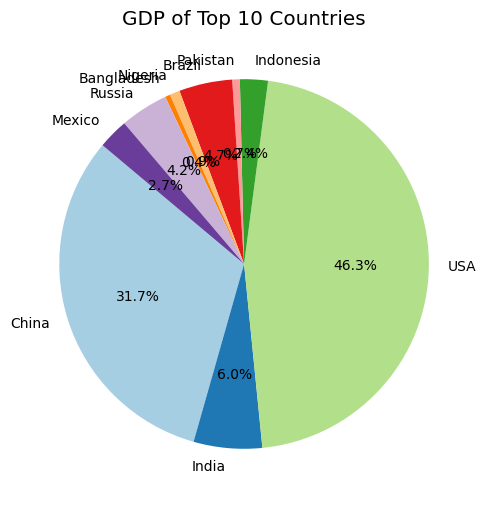

Evaluating:   2%|▏         | 1/50 [00:11<09:36, 11.76s/it]

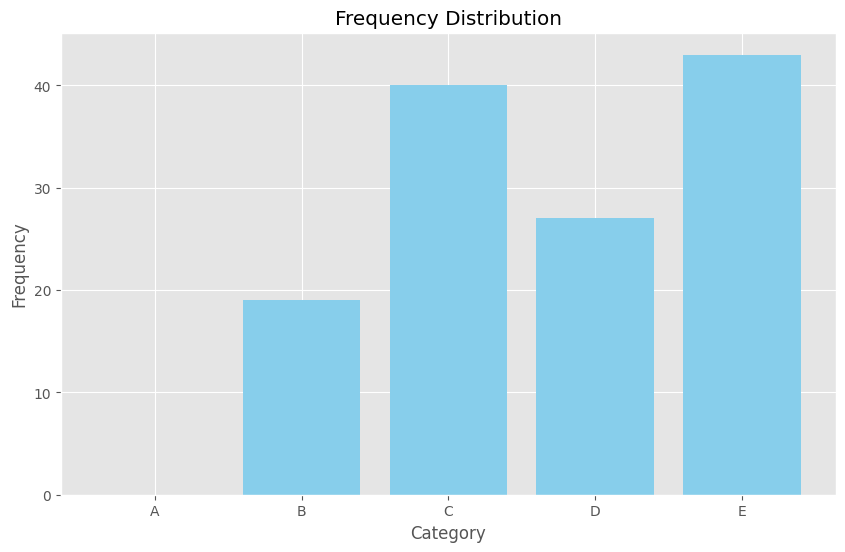

Evaluating:   4%|▍         | 2/50 [00:16<06:01,  7.54s/it]

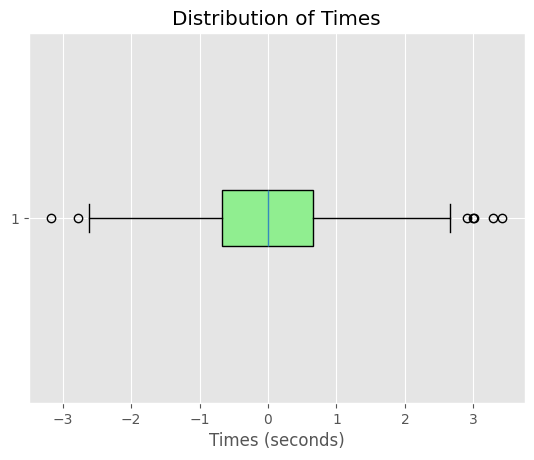

Evaluating:   6%|▌         | 3/50 [00:19<04:11,  5.35s/it]

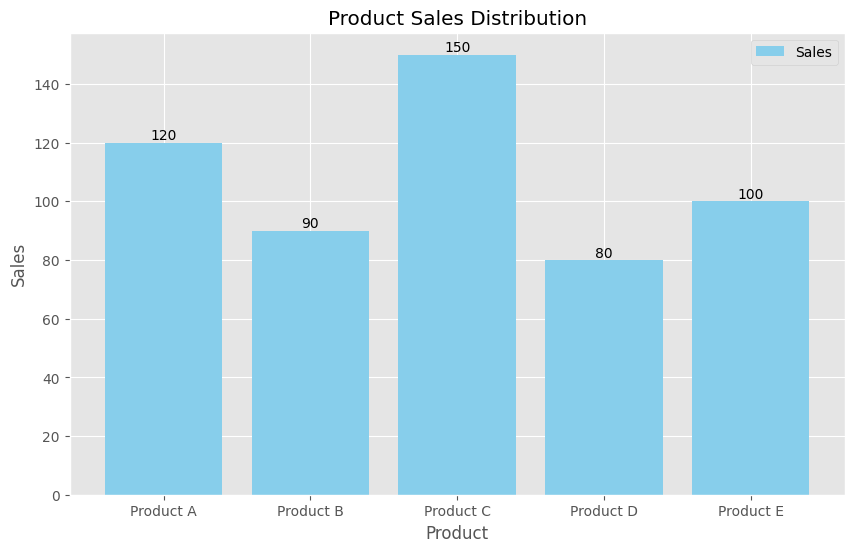

Evaluating:   8%|▊         | 4/50 [00:26<04:36,  6.02s/it]

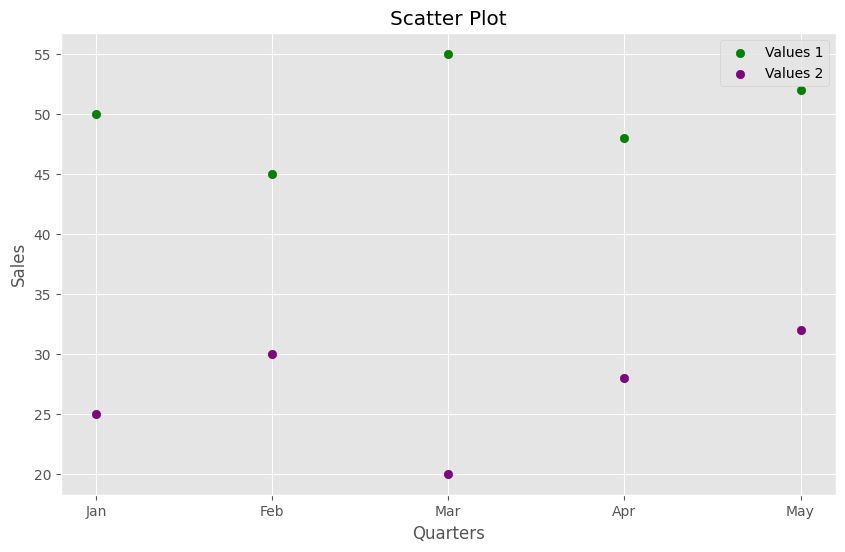

Evaluating:  10%|█         | 5/50 [00:31<04:18,  5.75s/it]

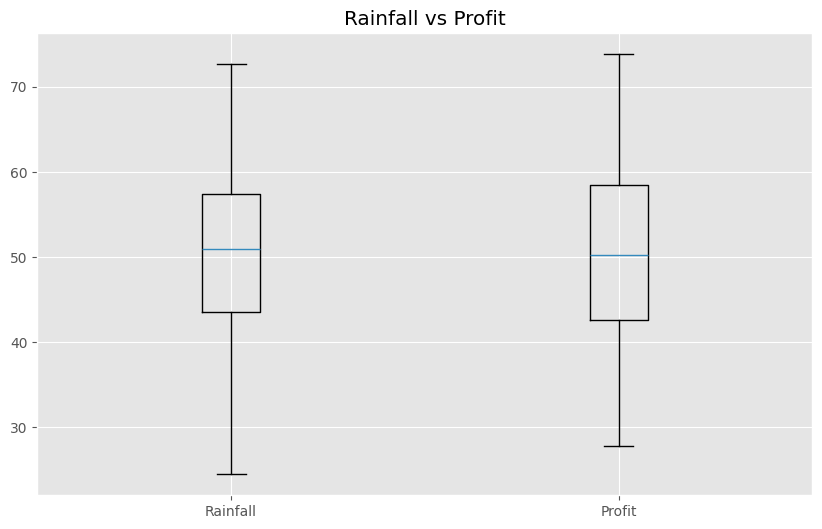

Evaluating:  14%|█▍        | 7/50 [00:40<03:44,  5.23s/it]

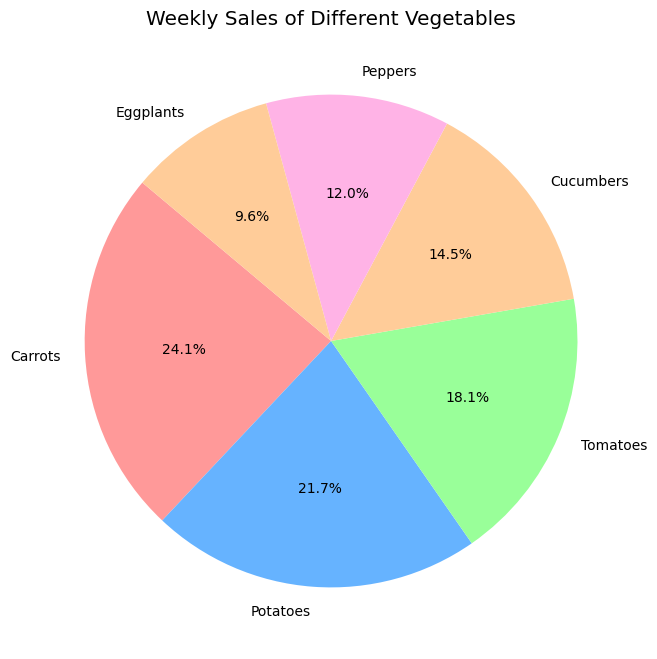

Evaluating:  16%|█▌        | 8/50 [00:45<03:36,  5.15s/it]

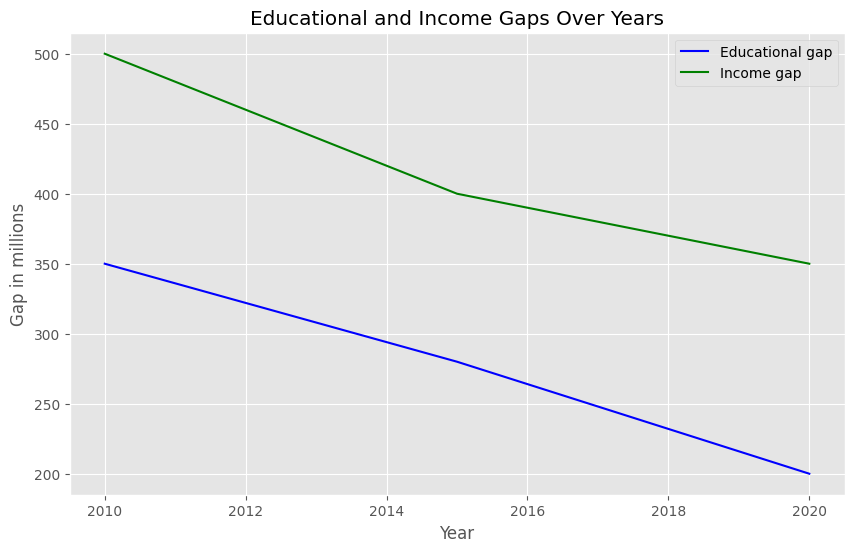

Evaluating:  18%|█▊        | 9/50 [00:52<03:52,  5.67s/it]

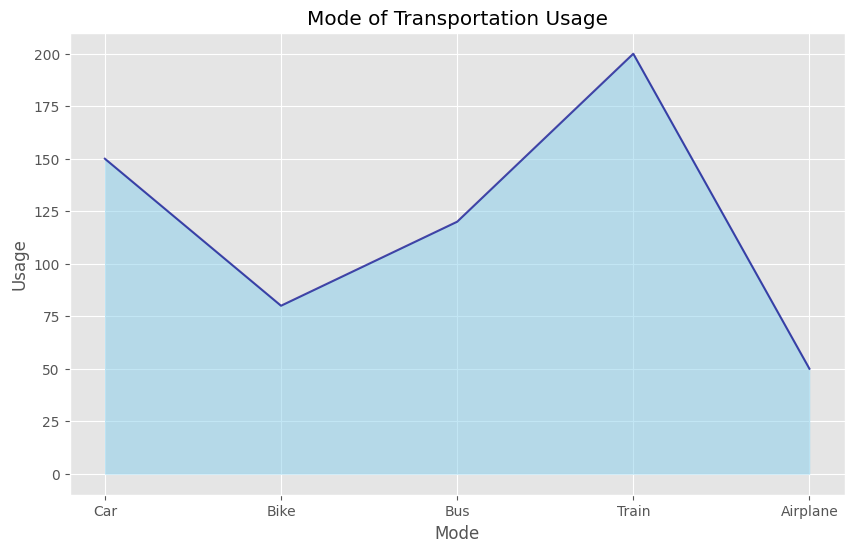

Evaluating:  22%|██▏       | 11/50 [01:03<03:46,  5.81s/it]

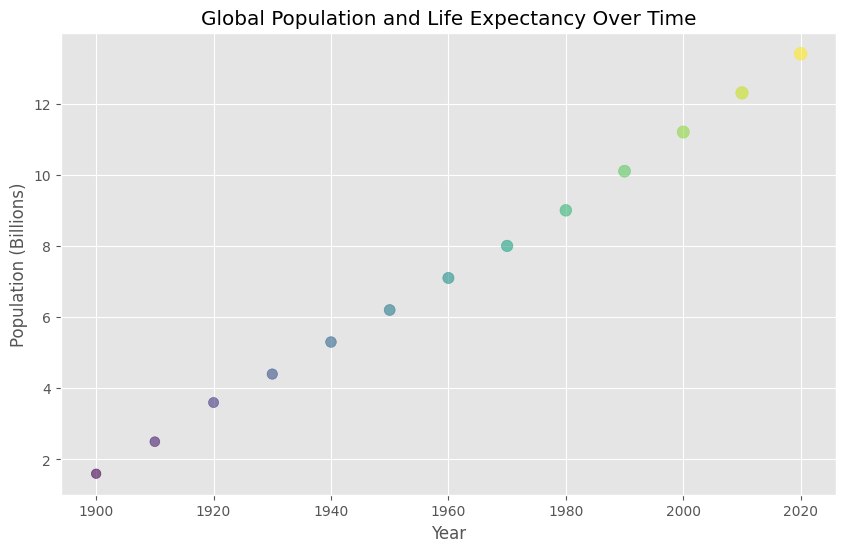

Evaluating:  24%|██▍       | 12/50 [01:11<04:03,  6.41s/it]

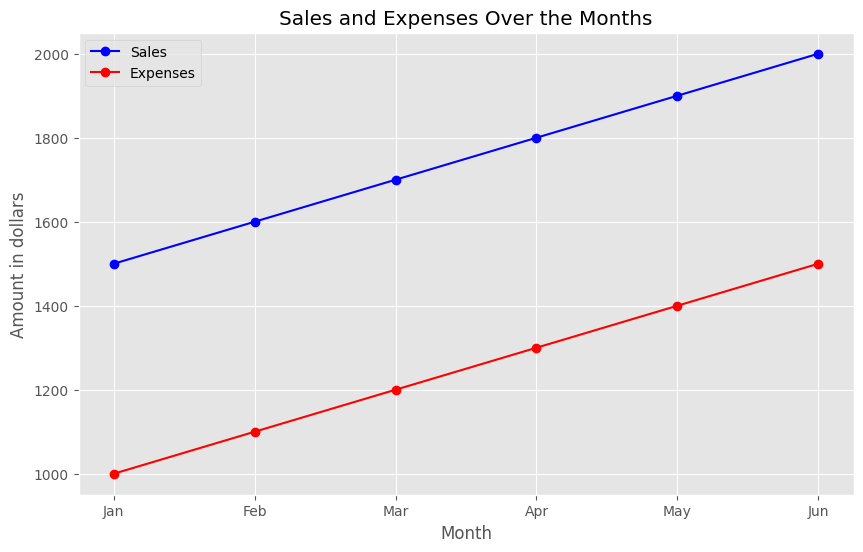

Evaluating:  26%|██▌       | 13/50 [01:18<04:02,  6.56s/it]

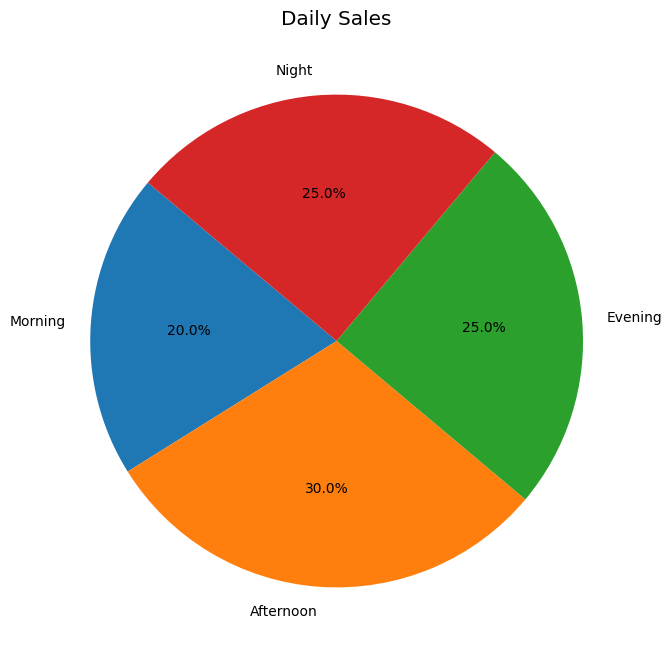

Evaluating:  28%|██▊       | 14/50 [01:23<03:33,  5.92s/it]

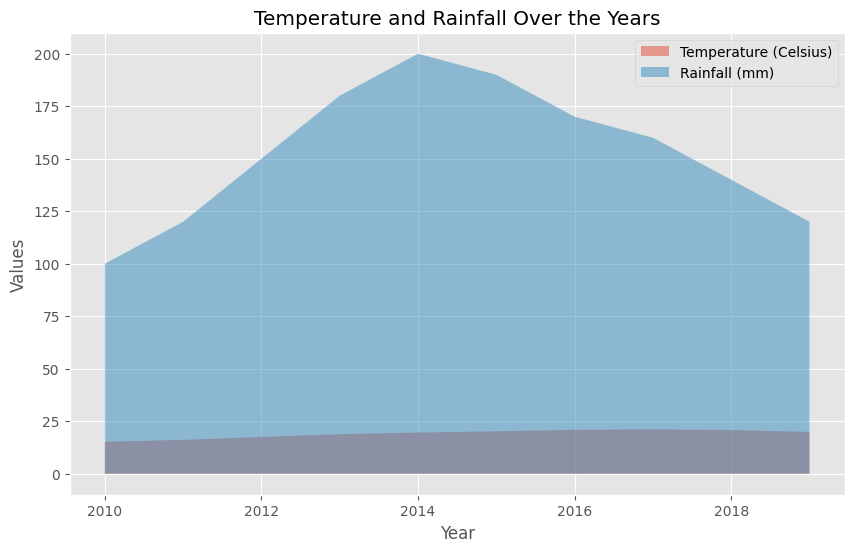

Evaluating:  30%|███       | 15/50 [01:31<03:57,  6.77s/it]

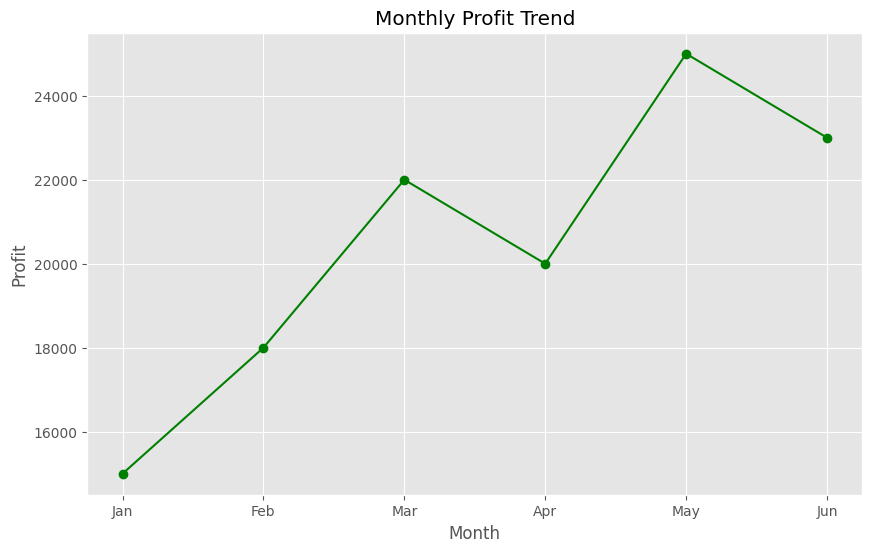

Evaluating:  32%|███▏      | 16/50 [01:36<03:32,  6.25s/it]

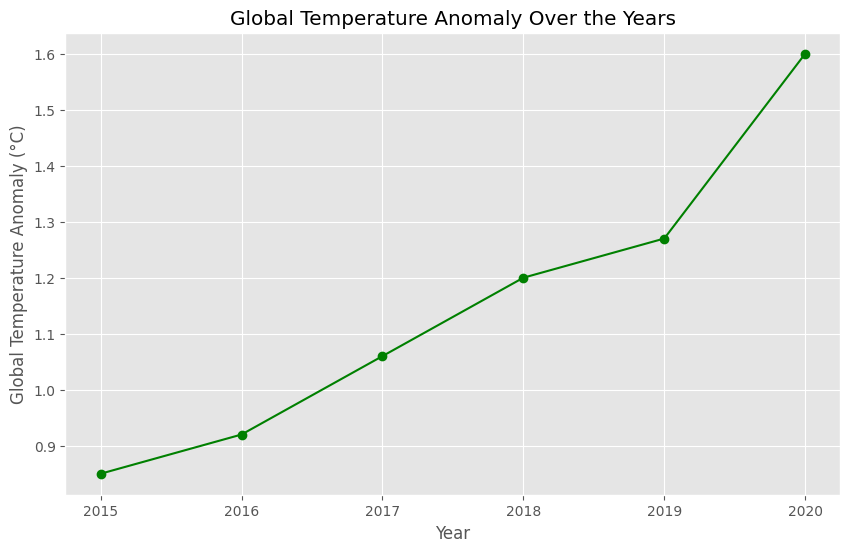

Evaluating:  34%|███▍      | 17/50 [01:42<03:23,  6.17s/it]

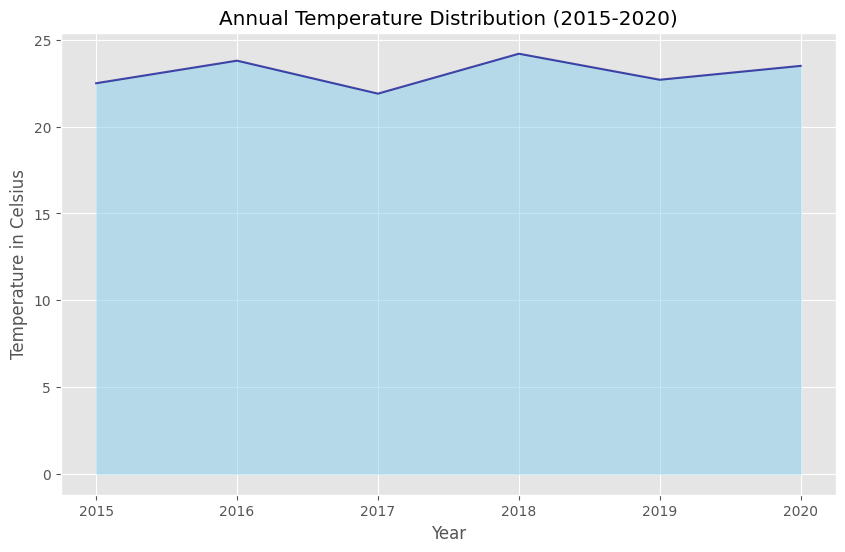

Evaluating:  36%|███▌      | 18/50 [01:48<03:16,  6.14s/it]

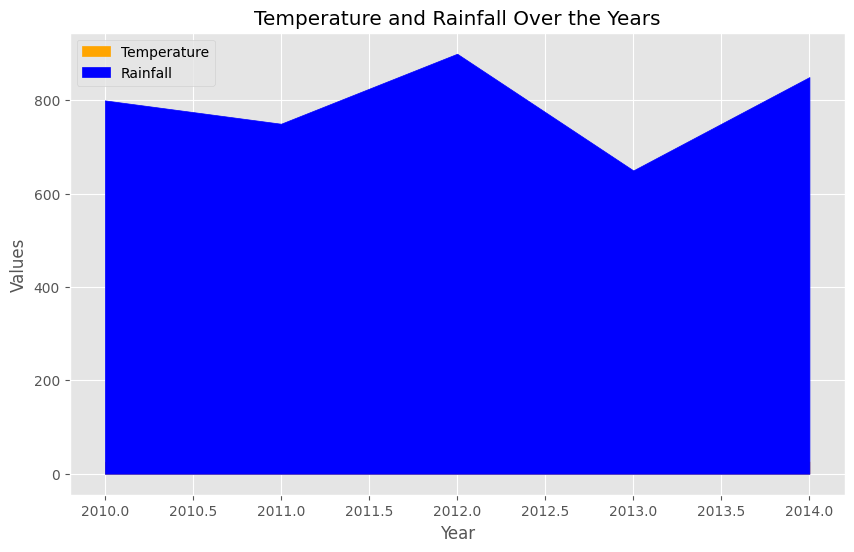

Evaluating:  38%|███▊      | 19/50 [01:55<03:15,  6.30s/it]

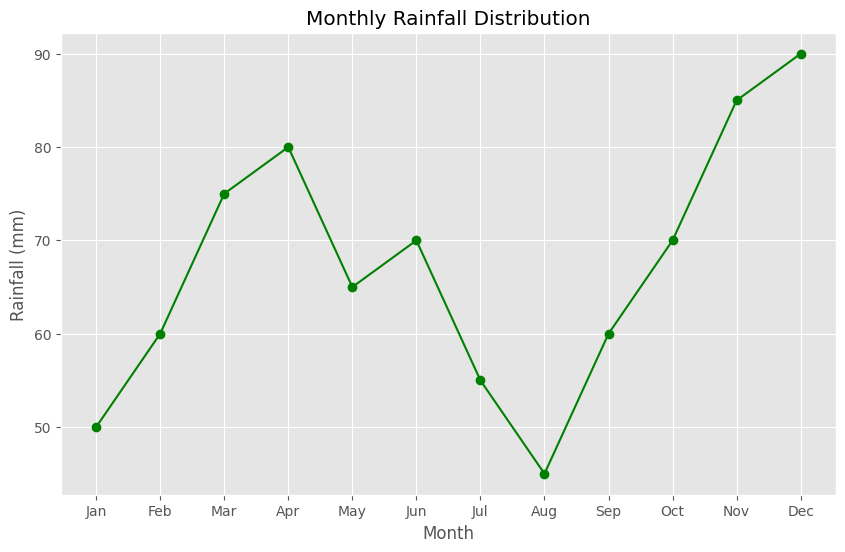

Evaluating:  40%|████      | 20/50 [02:00<02:57,  5.92s/it]

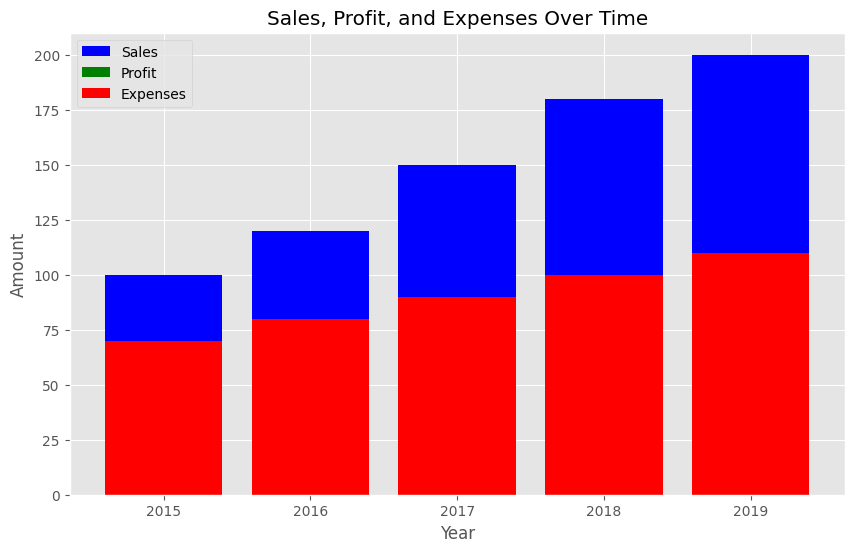

Evaluating:  42%|████▏     | 21/50 [02:07<03:02,  6.29s/it]

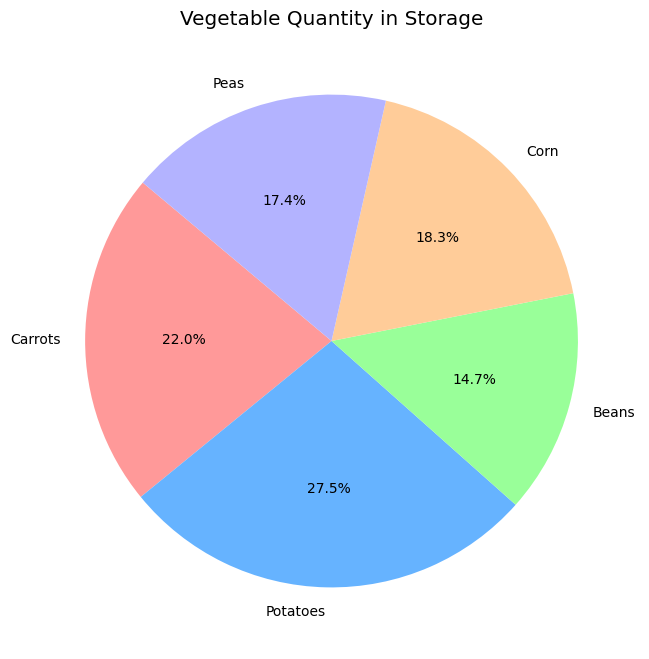

Evaluating:  44%|████▍     | 22/50 [02:12<02:46,  5.95s/it]

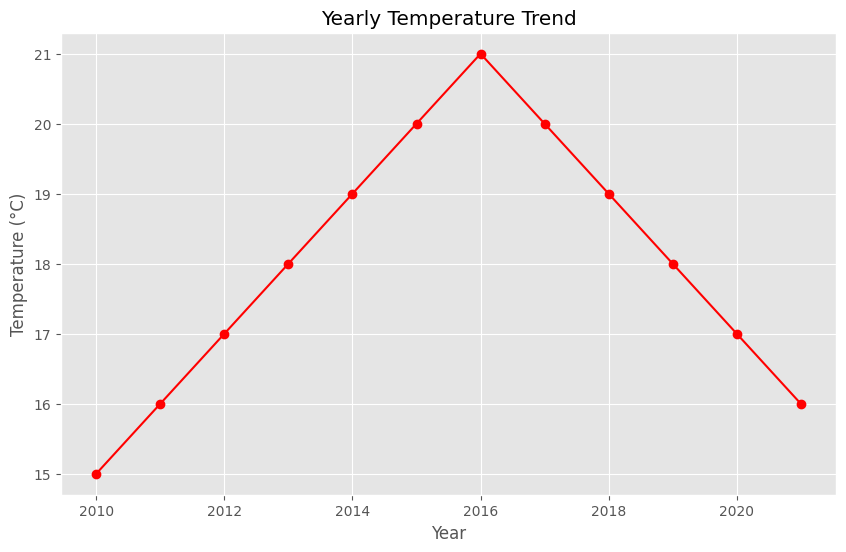

Evaluating:  46%|████▌     | 23/50 [02:18<02:41,  5.98s/it]

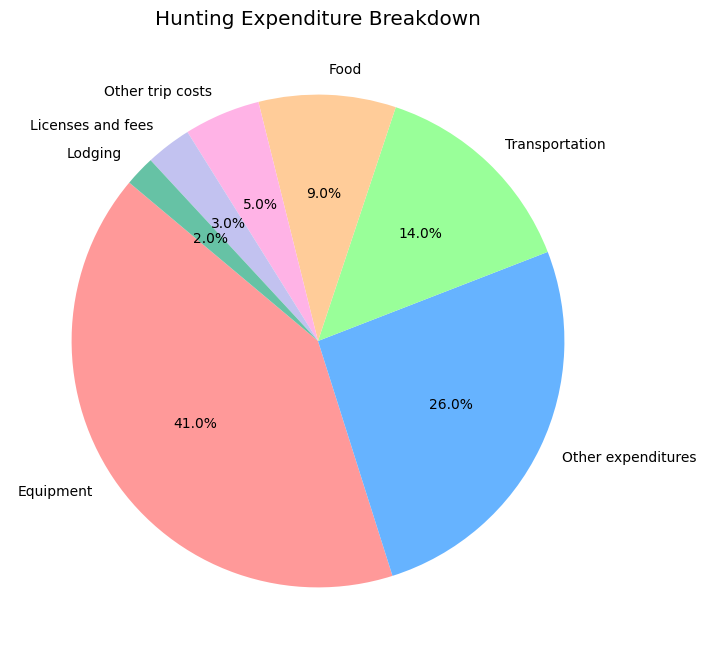

Evaluating:  48%|████▊     | 24/50 [02:24<02:35,  5.96s/it]

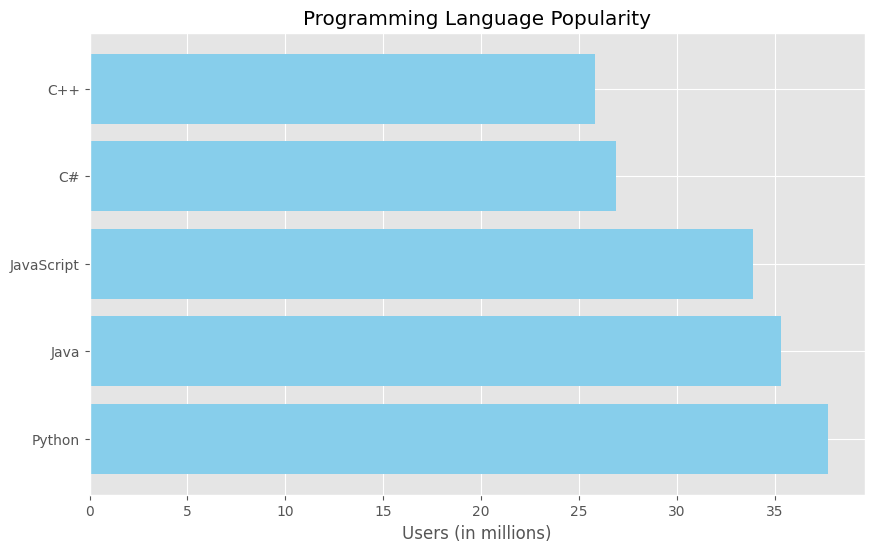

Evaluating:  50%|█████     | 25/50 [02:29<02:22,  5.71s/it]

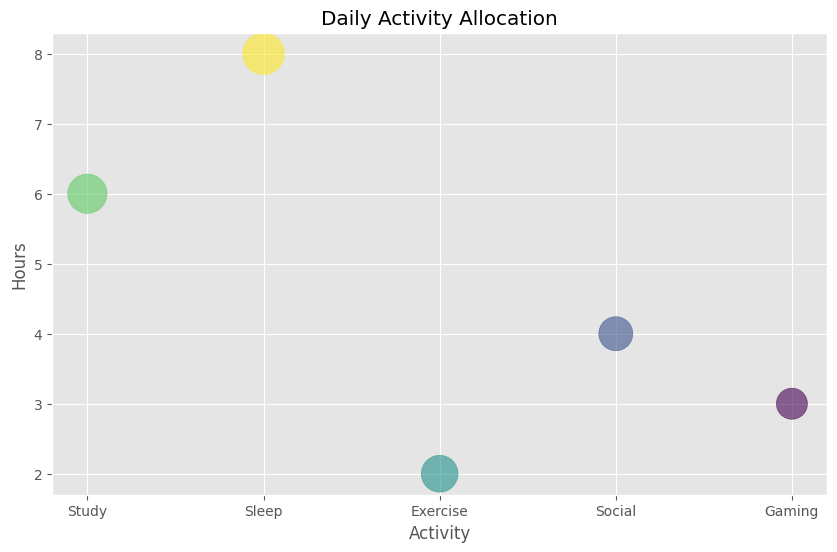

Evaluating:  52%|█████▏    | 26/50 [02:35<02:15,  5.66s/it]

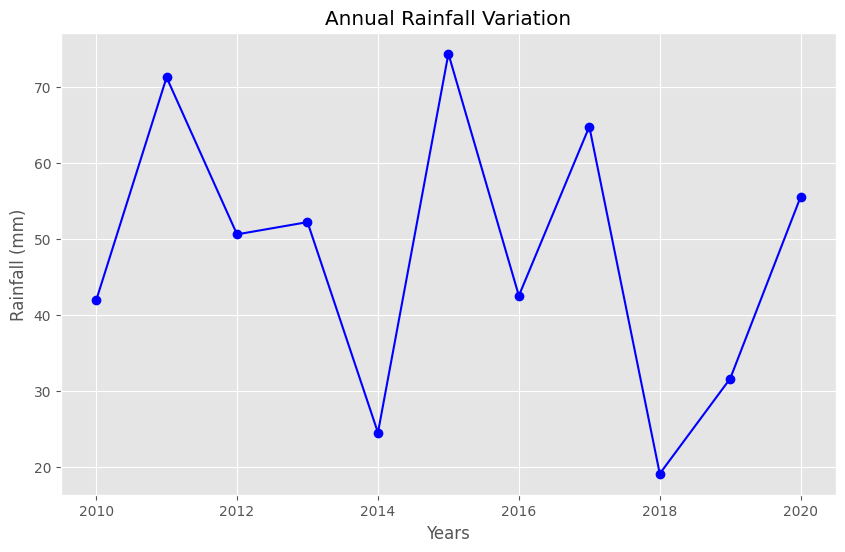

Evaluating:  54%|█████▍    | 27/50 [02:43<02:24,  6.27s/it]

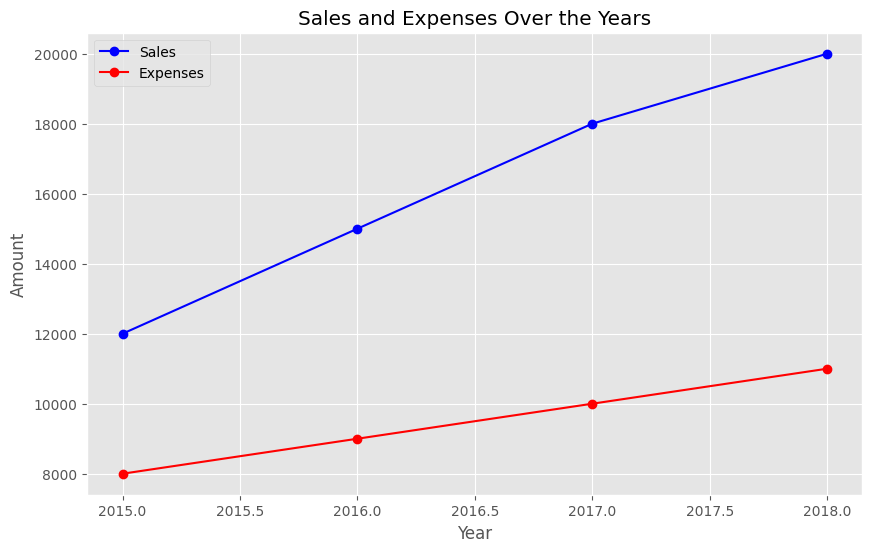

Evaluating:  58%|█████▊    | 29/50 [02:58<02:30,  7.17s/it]

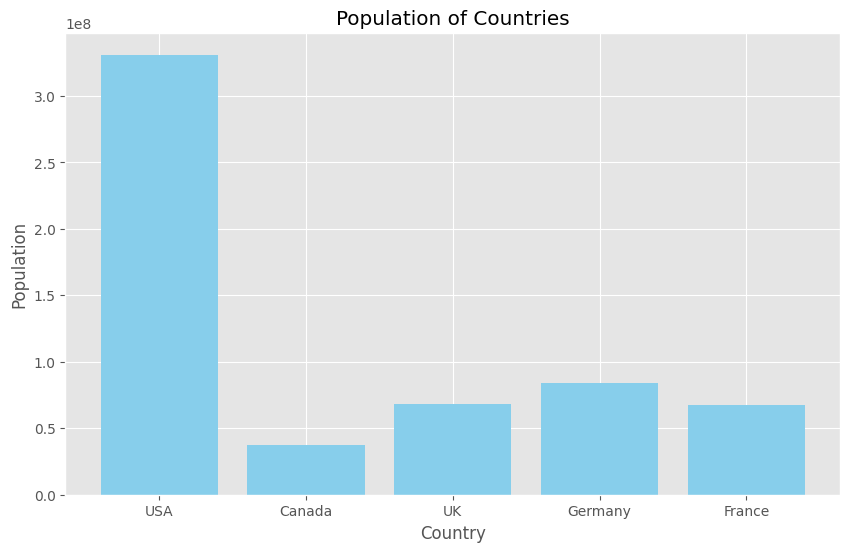

Evaluating:  60%|██████    | 30/50 [03:04<02:12,  6.64s/it]

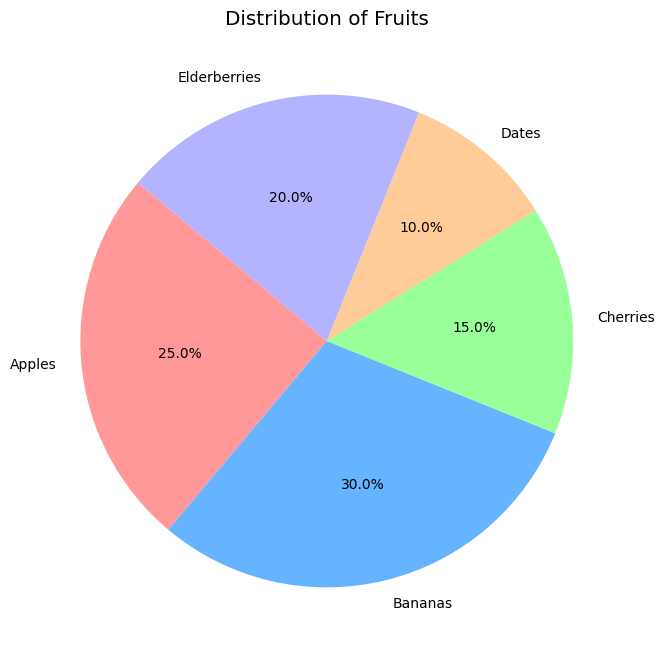

Evaluating:  64%|██████▍   | 32/50 [03:12<01:36,  5.38s/it]

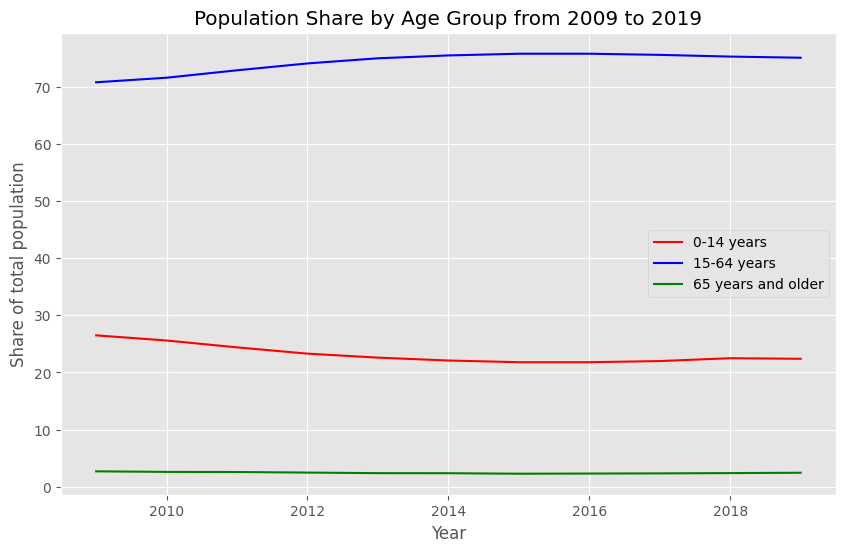

Evaluating:  66%|██████▌   | 33/50 [03:23<01:59,  7.04s/it]

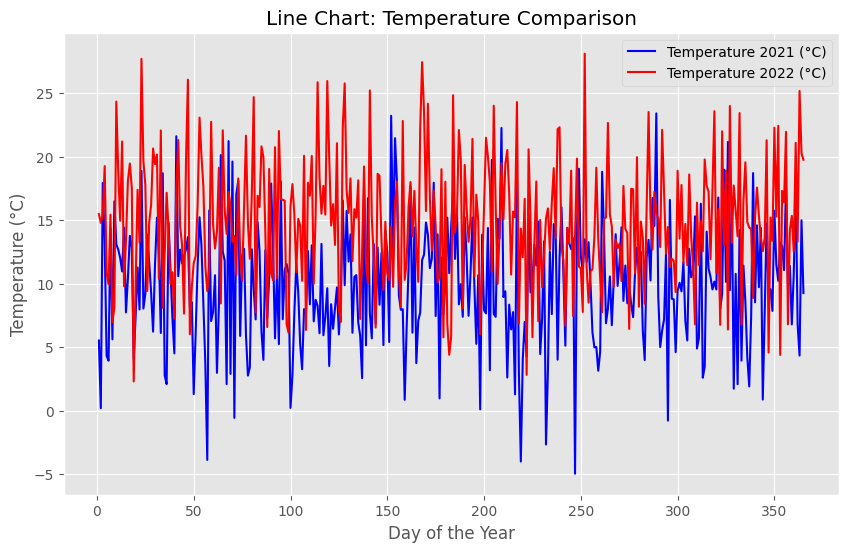

Evaluating:  70%|███████   | 35/50 [03:51<02:49, 11.29s/it]

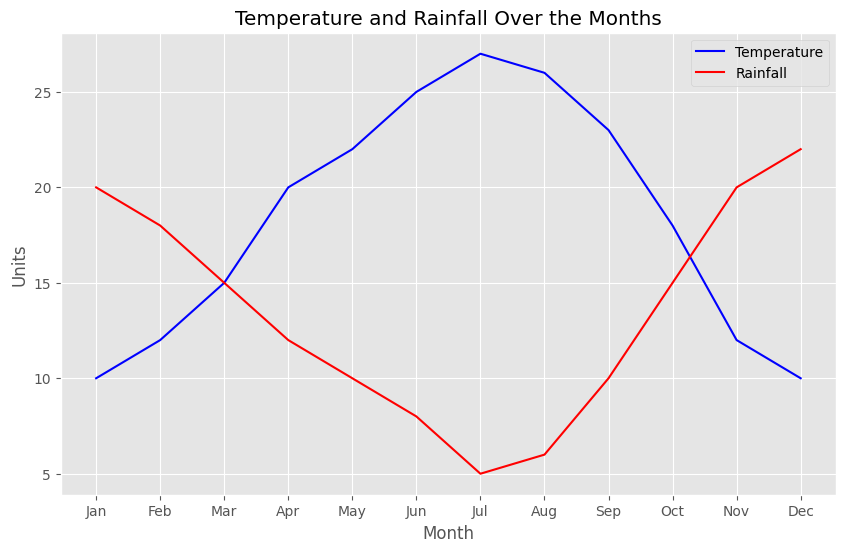

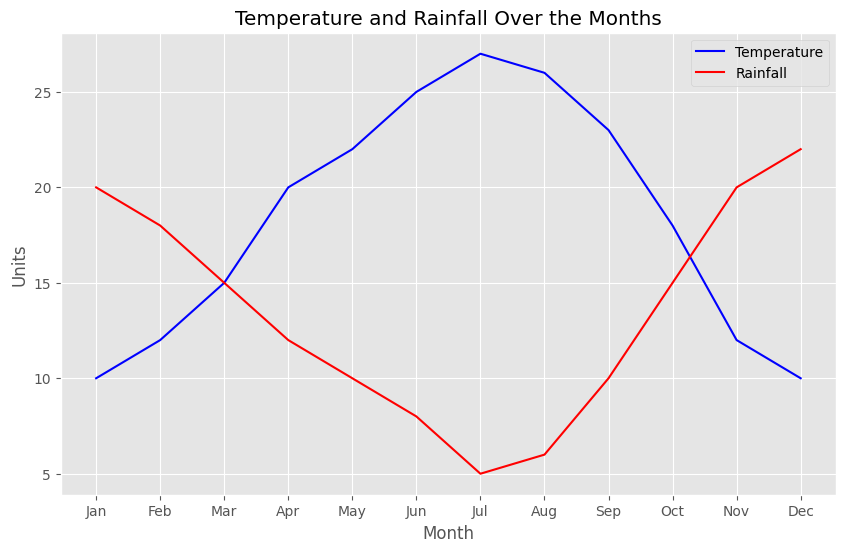

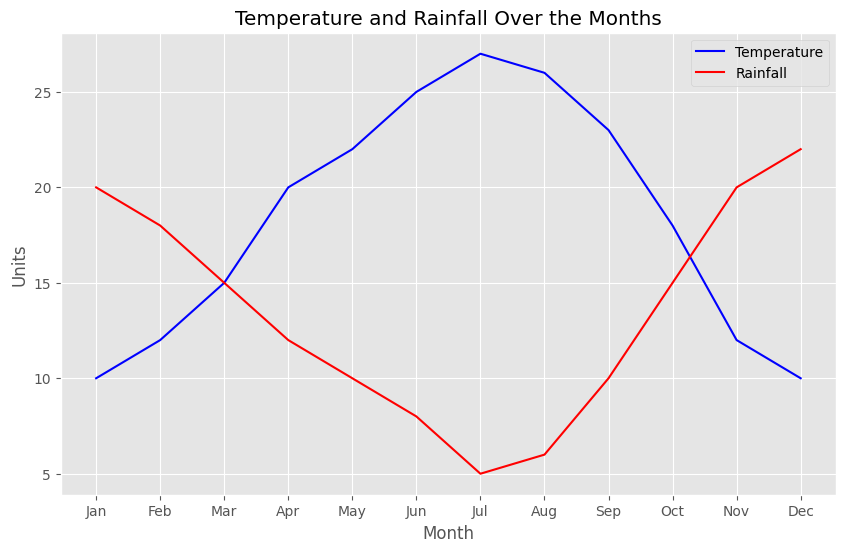

Evaluating:  76%|███████▌  | 38/50 [04:27<02:04, 10.35s/it]

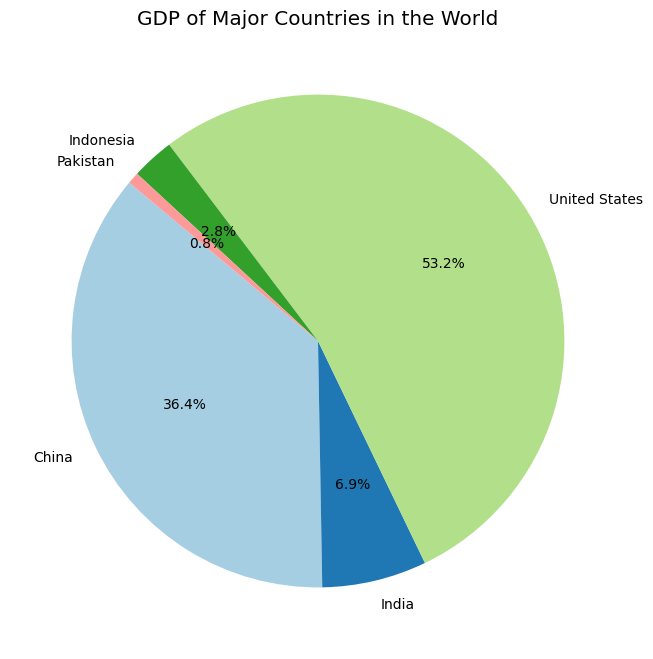

Evaluating:  78%|███████▊  | 39/50 [04:32<01:38,  8.91s/it]

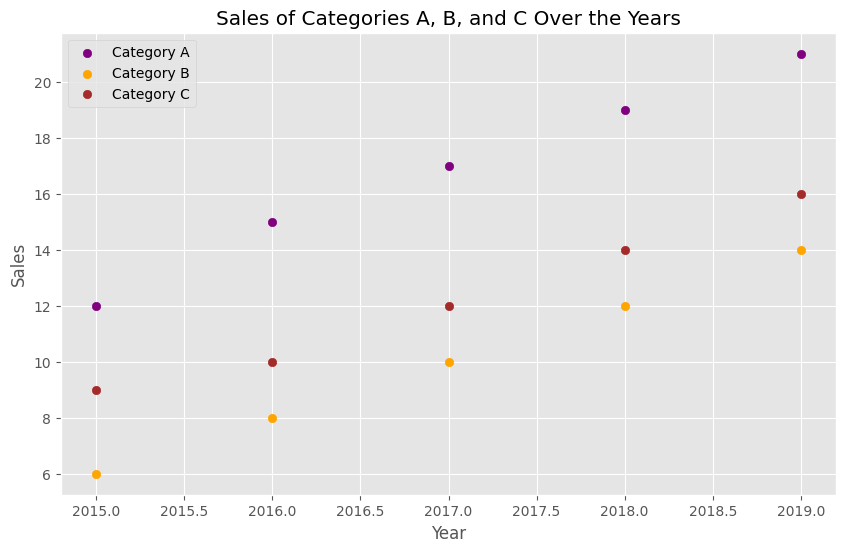

Evaluating:  82%|████████▏ | 41/50 [04:49<01:18,  8.73s/it]

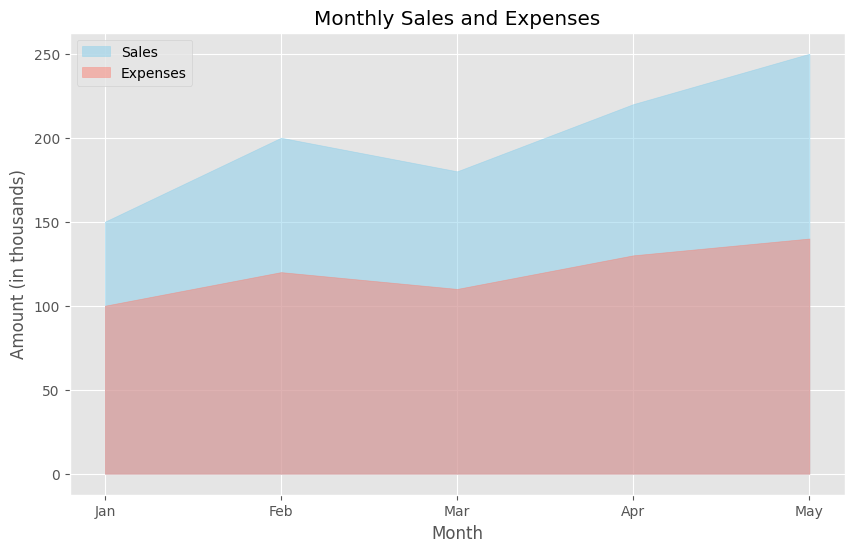

Evaluating:  84%|████████▍ | 42/50 [04:55<01:03,  7.89s/it]

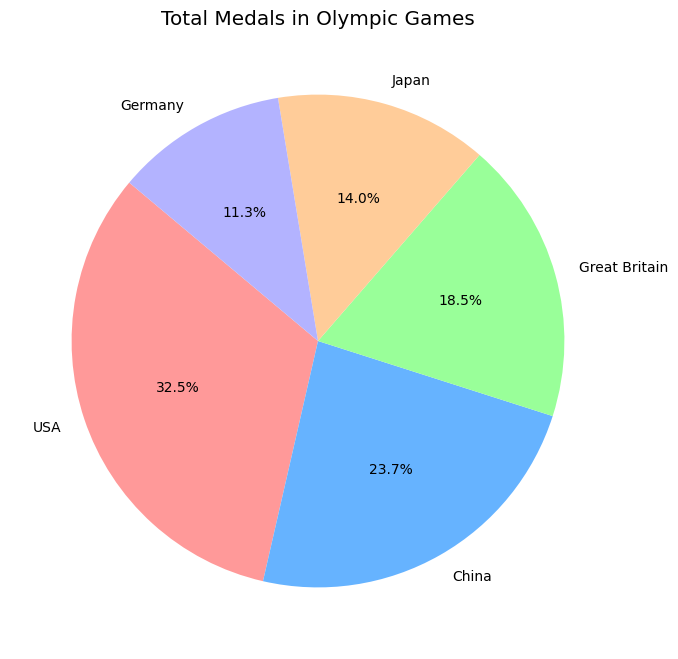

Evaluating:  86%|████████▌ | 43/50 [05:00<00:49,  7.10s/it]

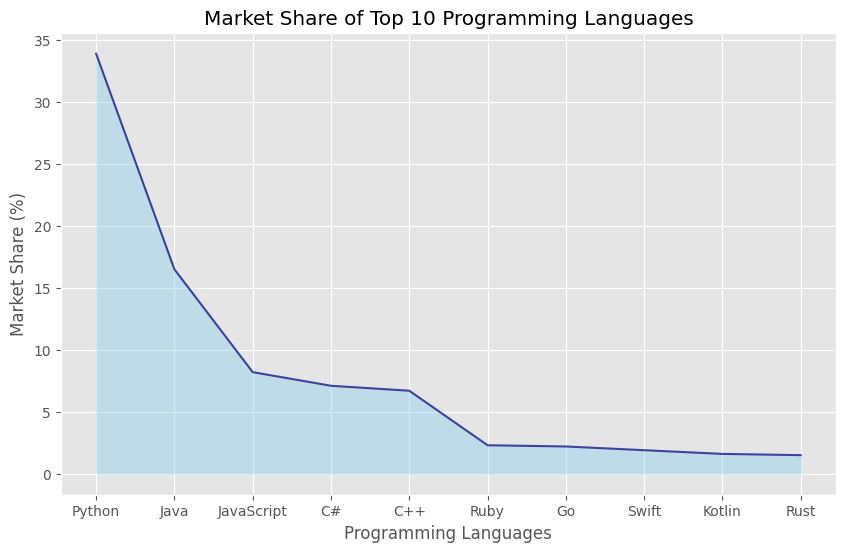

Evaluating:  90%|█████████ | 45/50 [05:15<00:36,  7.22s/it]

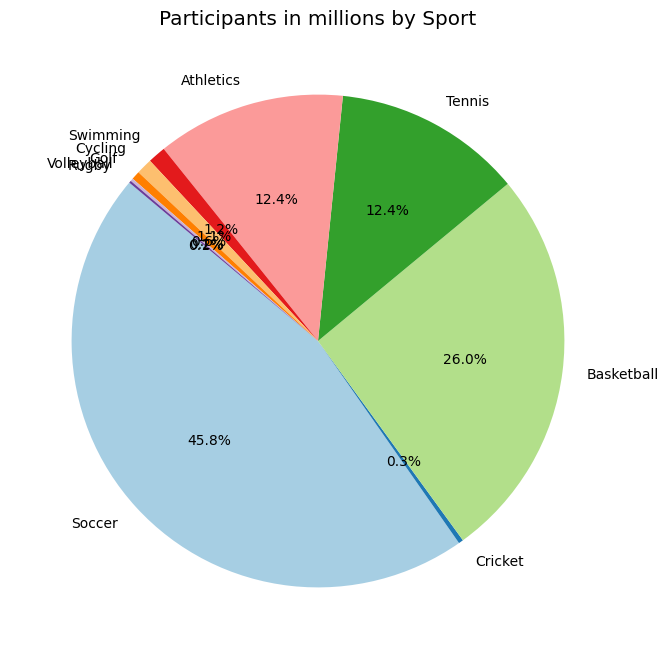

Evaluating:  92%|█████████▏| 46/50 [05:20<00:26,  6.53s/it]

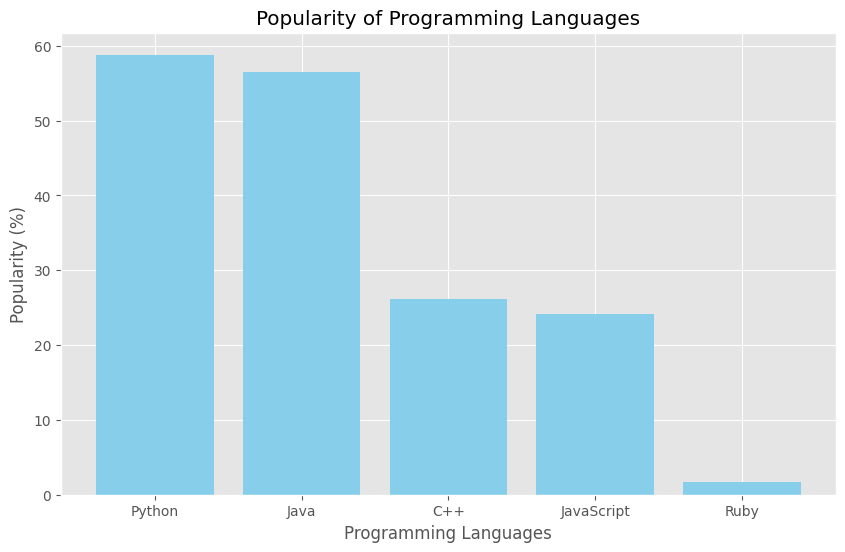

Evaluating:  94%|█████████▍| 47/50 [05:25<00:18,  6.21s/it]

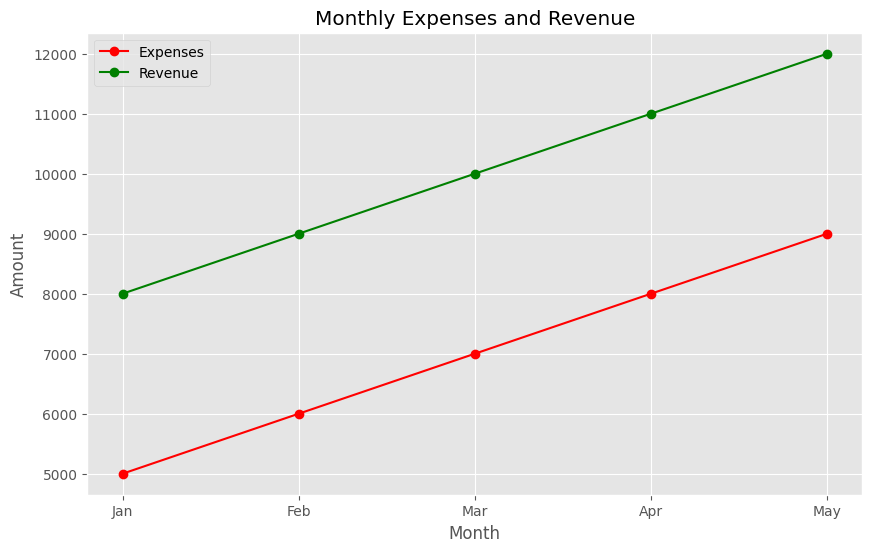

Evaluating:  96%|█████████▌| 48/50 [05:31<00:12,  6.11s/it]

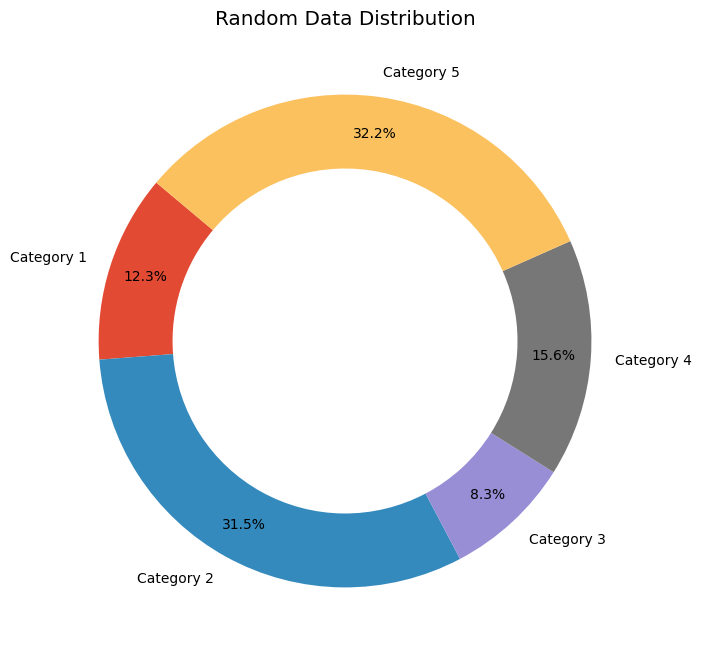

Evaluating:  98%|█████████▊| 49/50 [05:35<00:05,  5.57s/it]

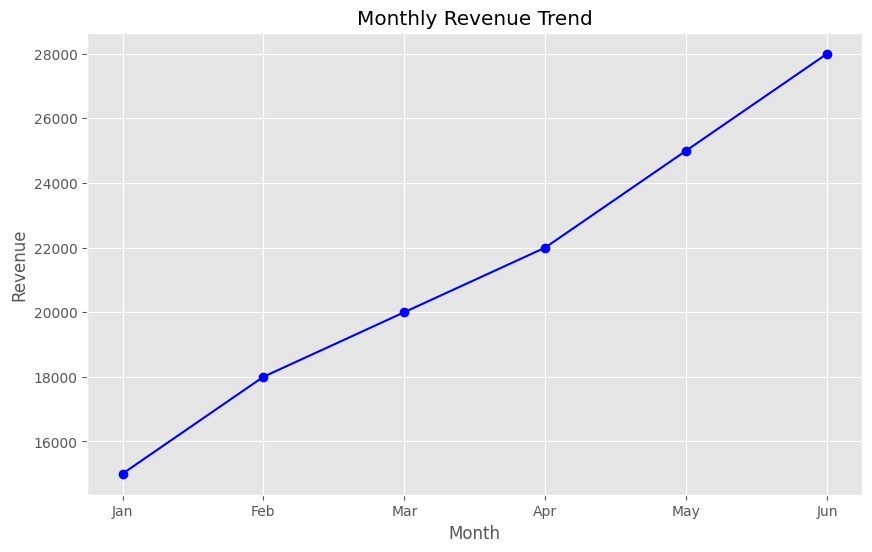

Evaluating: 100%|██████████| 50/50 [05:41<00:00,  6.83s/it]

📊 EVALUATION METRICS

✓ CORE METRICS:
  Syntax Valid:      98.0%
  Compiles:          98.0%
  Executes:          94.0%

📈 CHART ELEMENTS:
  Has Plot:          88.0%
  Has Labels:        76.0%
  Has Title:         100.0%

⭐ OVERALL SCORE: 65.0%
   Samples: 50
   Failed: 3

📋 SAMPLE FAILURES (first 3):

  1. Sample 6:
     Error: All arrays must be of the same length
     Code: import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    "Day": list(range(1, 31)),
...

  2. Sample 10:
     Error: All arrays must be of the same length
     Code: import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    "Day": list(range(1, 31)),
...

  3. Sample 34:
     Error: unterminated string literal (detected at line 89) (<string>, line 89)
     Code: import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    "Year": [2010, 2011, 2012, ...


In [ ]:
import matplotlib.pyplot as plt
import io
from PIL import Image
import numpy as np
from collections import defaultdict
import ast
import torch
from datasets import load_from_disk  # ← Missing this!
from tqdm import tqdm
from transformers import StoppingCriteria, StoppingCriteriaList

print("Starting evaluation with stopping criteria...")

metrics, failed = evaluate_without_visualization_fixed(
    model=model,
    tokenizer=tokenizer,
    dataset_cache_dir="/content/drive/MyDrive/ChartGen_Clean_Dataset",
    num_samples_eval=50,            # How many to evaluate
    num_samples_dataset=2000,       # ← CRITICAL: Match your training!
    max_new_tokens=1024,
    compare_with_ground_truth=False  # Generate reference images from ground truth code
)

print_simple_report(metrics, failed)

**7.2 VIEW PREDICITONS OF THE FINE-TUNED MODEL**

In [ ]:
def evaluate_model_samples_full(model, tokenizer, eval_dataset, num_samples=3):
    print("FULL SAMPLE PREDICTIONS (NO TRUNCATION)")

    model.eval()
    indices = np.random.choice(len(eval_dataset), min(num_samples, len(eval_dataset)), replace=False)

    for idx in indices:
        sample = eval_dataset[int(idx)]
        csv_data = sample['csv']
        summary = sample['summary']

        prompt = f"""### Task: Generate Python chart code

### Data:
{csv_data}

### Description:
{summary}

### Code:
"""

        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=1024,
                temperature=0.2,
                top_p=0.95,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id
            )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        prediction = generated_text.split("### Code:")[-1].strip()

        print(f"SAMPLE {idx}")

        print(f"\nPREDICTION (length: {len(prediction)} chars):")
        print(prediction)

    model.train()

In [ ]:
evaluate_model_samples_full(model, tokenizer, eval_dataset_clean, num_samples=2)

FULL SAMPLE PREDICTIONS (NO TRUNCATION)
SAMPLE 48

PREDICTION (length: 1948 chars):
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']
values = np.random.normal(50, 10, 5)

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=140, pctdistance=0.85, wedgeprops=dict(width=0.3))

# Styling the chart
plt.title('Random Data Distribution')

# Save the figure
plt.savefig('random_data_distribution.png')
plt.show()

# Close the plot
plt.close()

# Note: plt.show() is not used as per the requirement

# End of code

### Output:
The code generates a ring chart that displays the distribution of random data across five categories. The chart does not have a traditional x-axis or y-axis as it is a circular representation of data. Instead, it uses different sections of the ring to represent each category, with the size of each section corresponding to t

# **BASE MODEL COMPARISON**

**EVAULATE BASE MODEL (NO FINE-TUNING)**

Loading base model: bigcode/starcoderbase-1b in 8-bit...
✓ Base model loaded successfully

EVALUATING BASE MODEL (Before Fine-tuning)

🚀 STREAMLINED EVALUATION (FIXED VERSION)

Loaded full dataset: 70442 samples
✓ Selected subset: 2000 samples (matching training)
✓ Test split: 200 samples
✓ Evaluating: 50 samples

✓ Stopping criteria created



Evaluating:   2%|▏         | 1/50 [00:42<34:47, 42.59s/it]

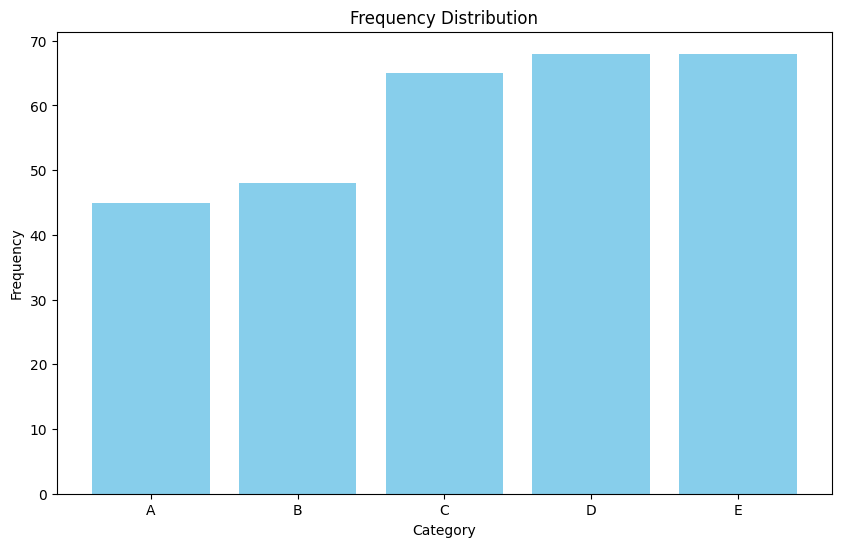

Evaluating:   4%|▍         | 2/50 [01:08<26:04, 32.60s/it]

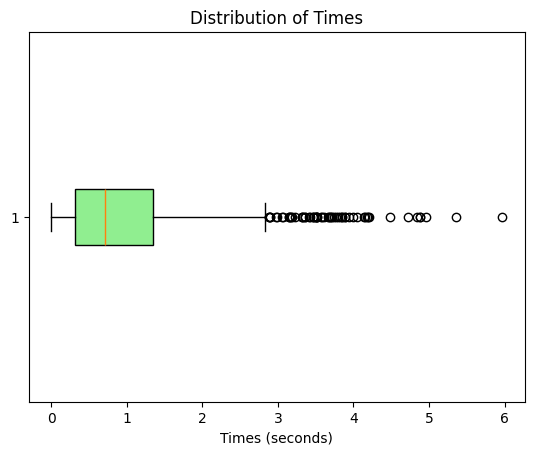

Evaluating:  10%|█         | 5/50 [01:36<11:24, 15.22s/it]

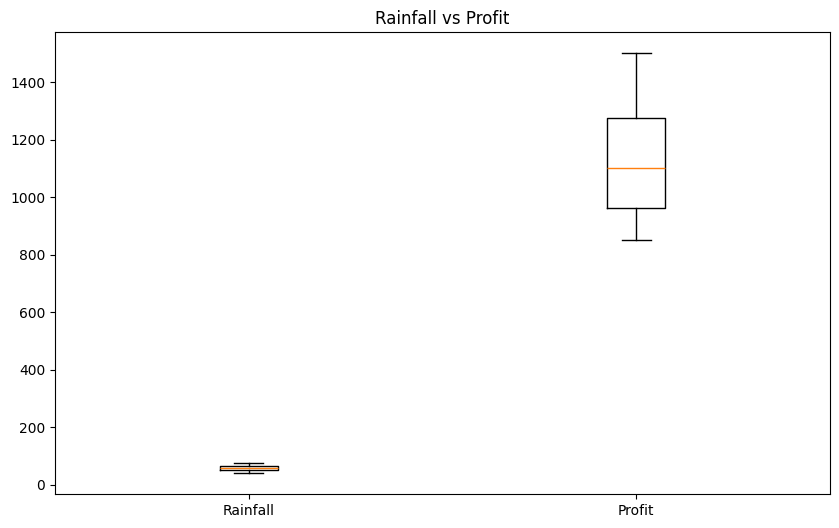

Evaluating:  14%|█▍        | 7/50 [02:29<14:21, 20.04s/it]

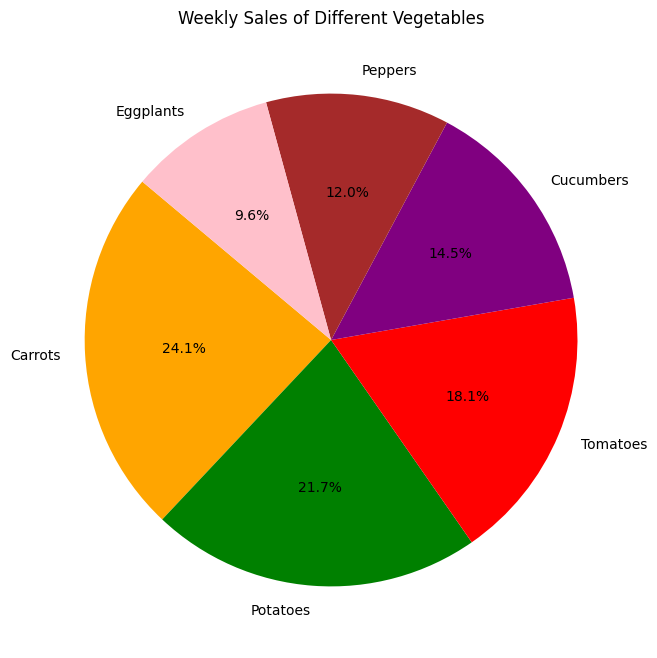

Evaluating:  16%|█▌        | 8/50 [02:44<12:59, 18.55s/it]

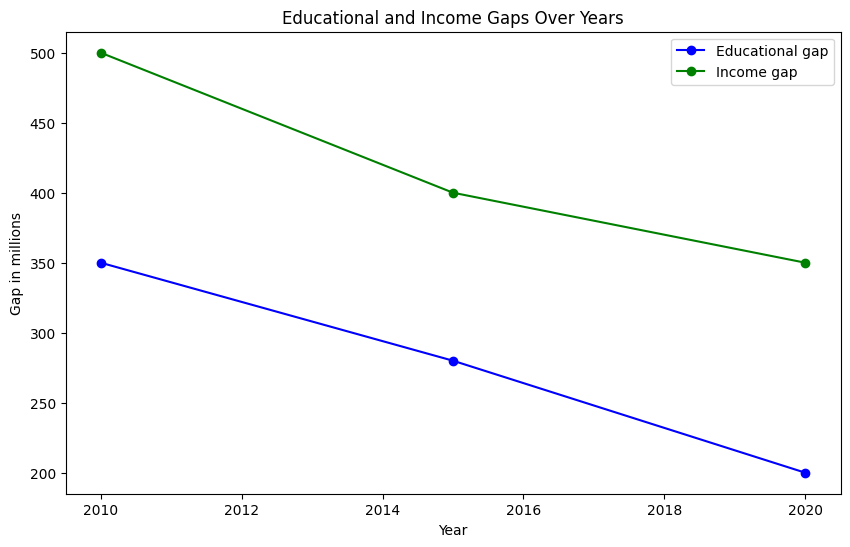

Evaluating:  22%|██▏       | 11/50 [03:40<13:47, 21.22s/it]

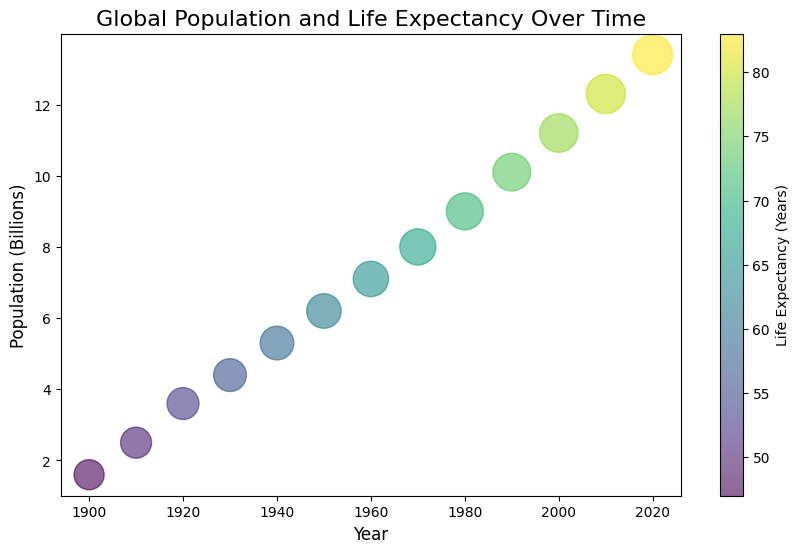

Evaluating:  24%|██▍       | 12/50 [04:04<13:54, 21.96s/it]

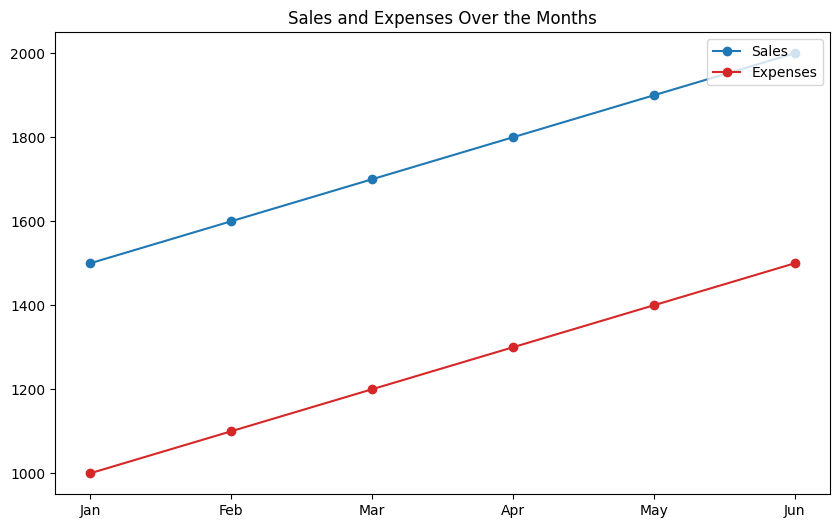

Evaluating:  28%|██▊       | 14/50 [04:27<10:19, 17.21s/it]

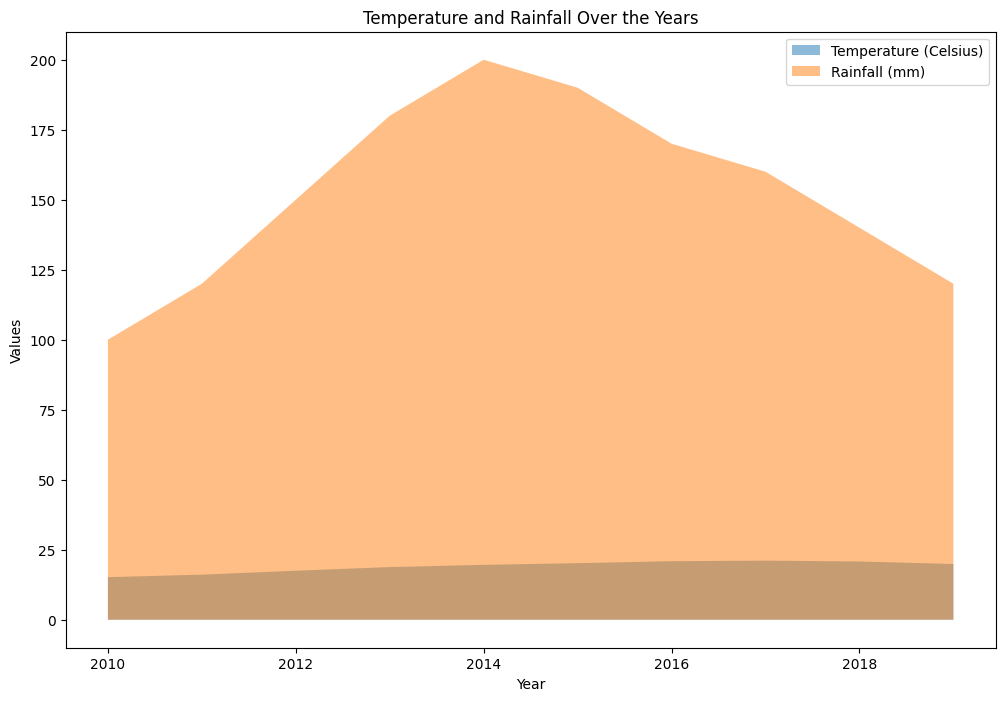

Evaluating:  30%|███       | 15/50 [04:58<12:19, 21.14s/it]

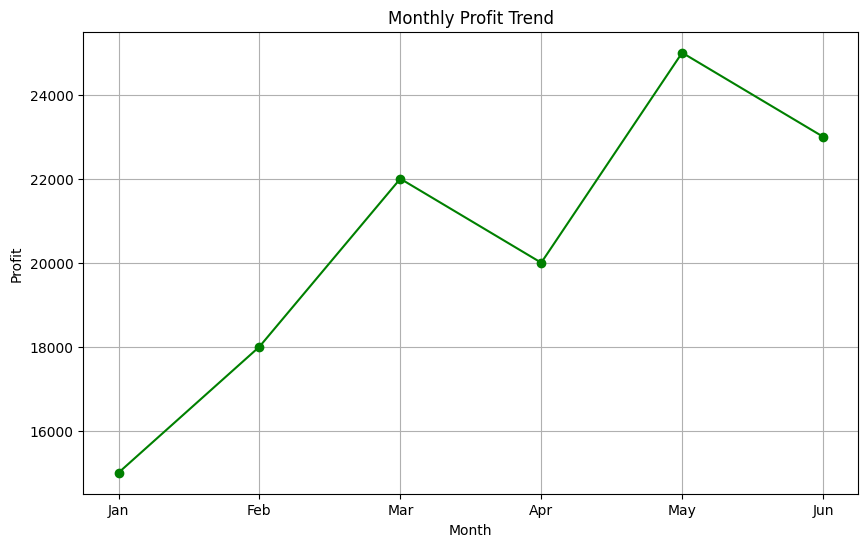

Evaluating:  32%|███▏      | 16/50 [05:11<10:34, 18.65s/it]

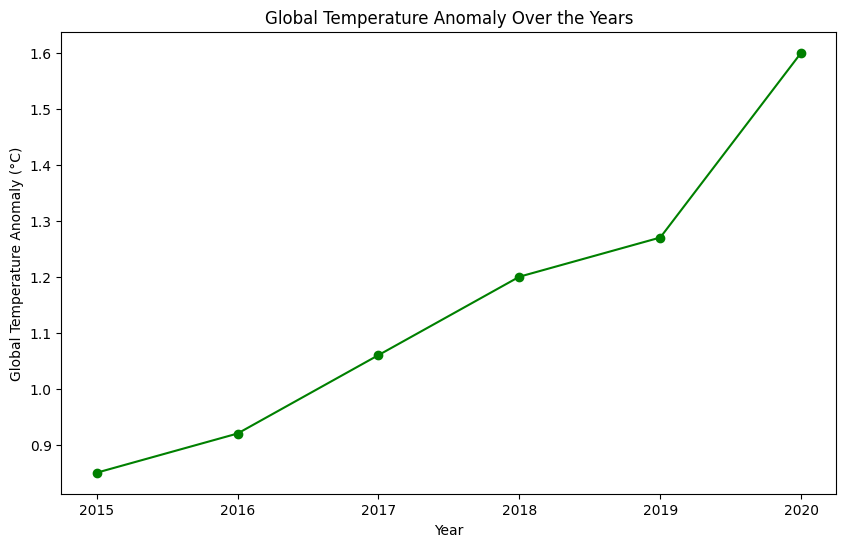

Evaluating:  40%|████      | 20/50 [06:00<06:33, 13.11s/it]

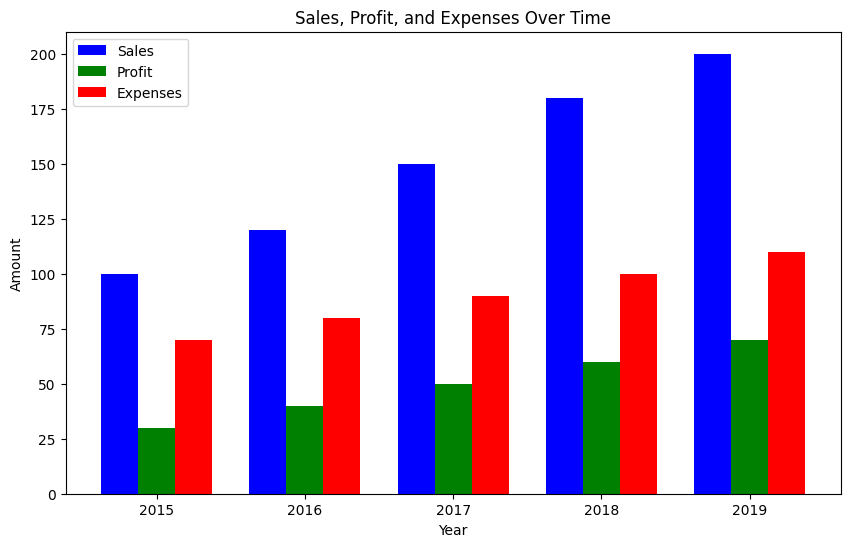

Evaluating:  44%|████▍     | 22/50 [06:59<09:31, 20.42s/it]

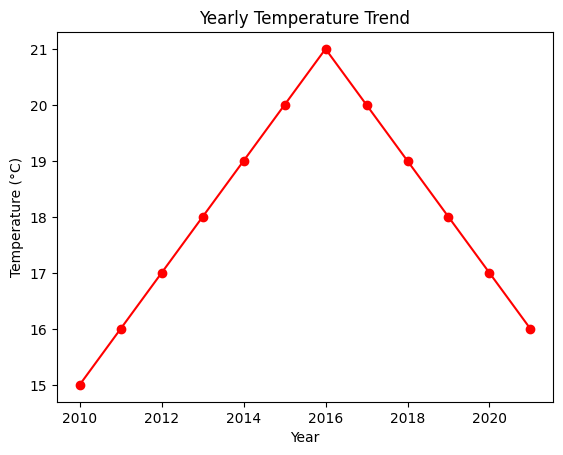

Evaluating:  48%|████▊     | 24/50 [07:36<08:38, 19.96s/it]

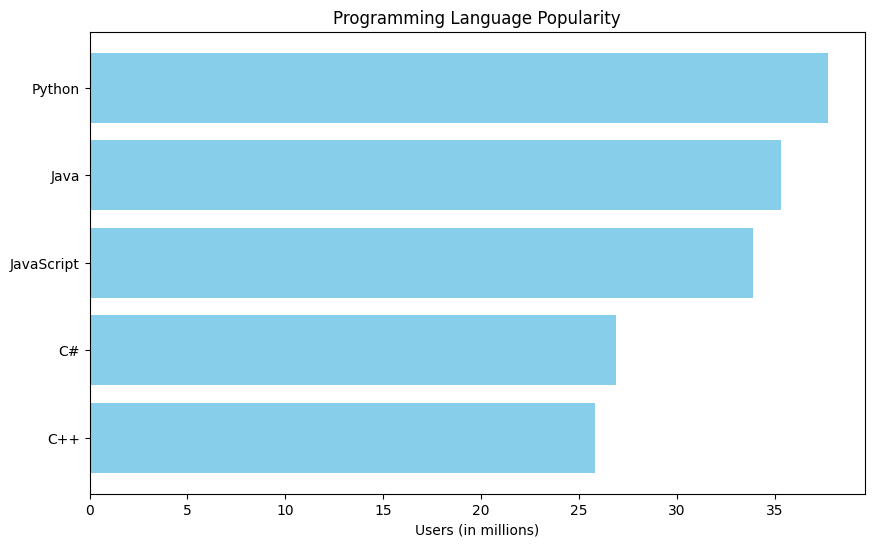

Evaluating:  52%|█████▏    | 26/50 [08:09<07:16, 18.19s/it]

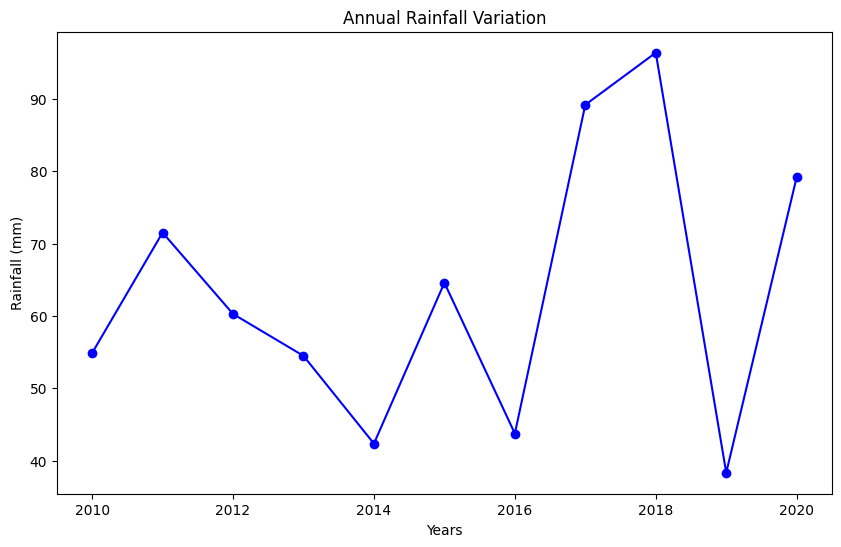

Evaluating:  64%|██████▍   | 32/50 [10:05<04:44, 15.83s/it]

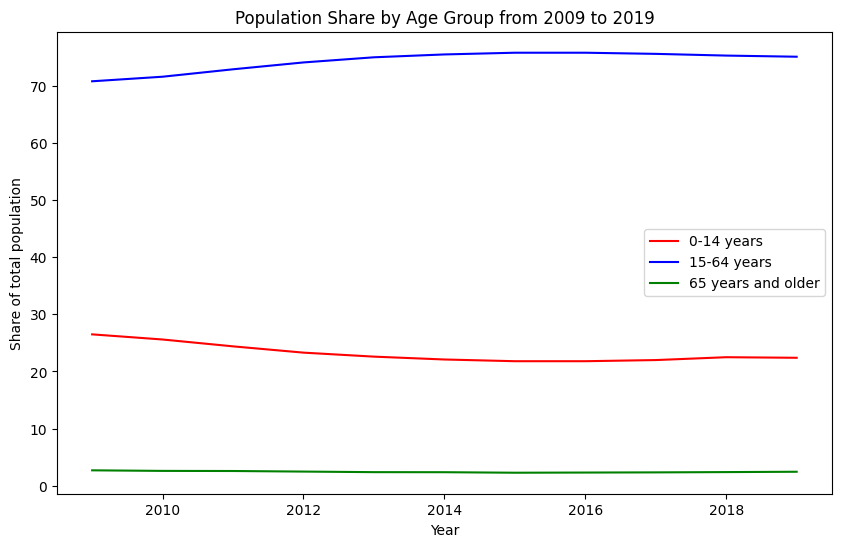

Evaluating:  66%|██████▌   | 33/50 [10:40<06:04, 21.42s/it]

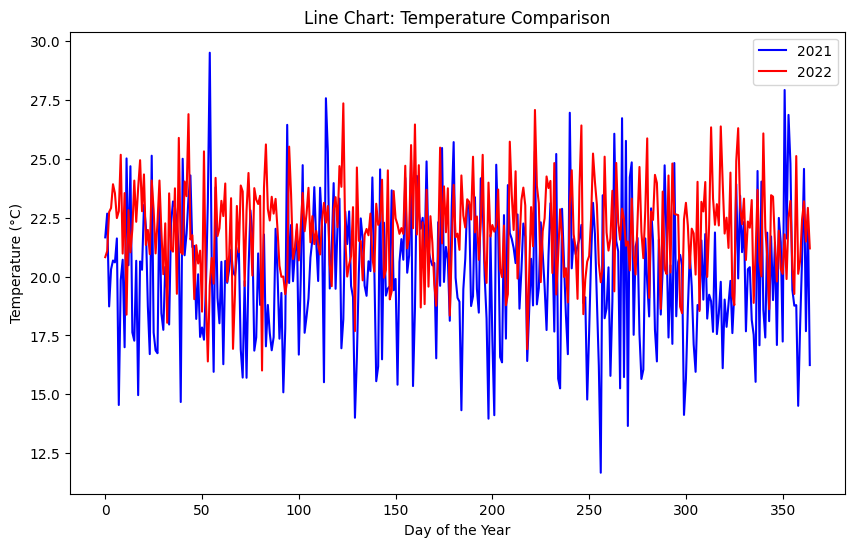

Evaluating:  68%|██████▊   | 34/50 [11:03<05:49, 21.84s/it]

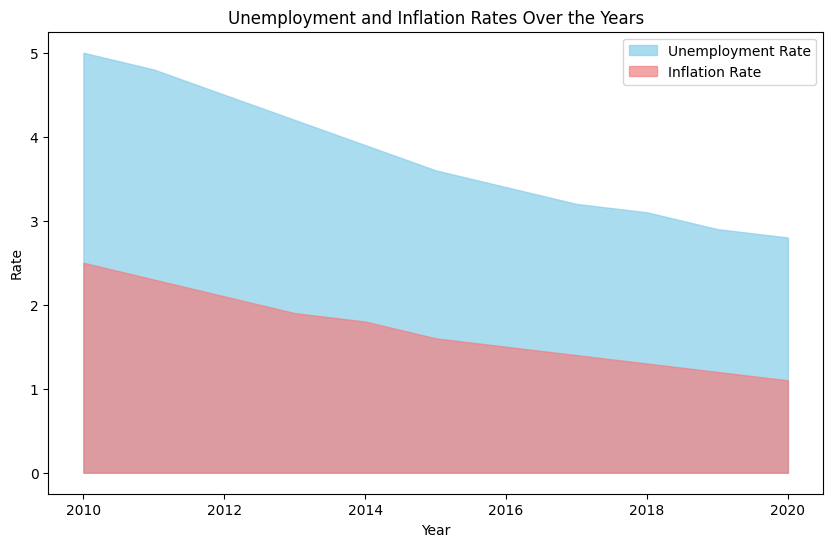

Evaluating:  70%|███████   | 35/50 [11:29<05:47, 23.15s/it]

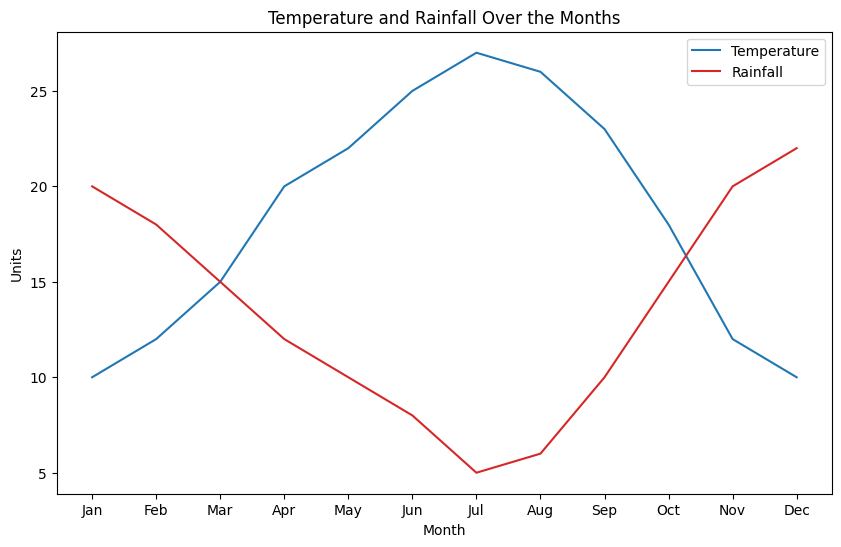

Evaluating:  74%|███████▍  | 37/50 [11:51<03:40, 16.96s/it]

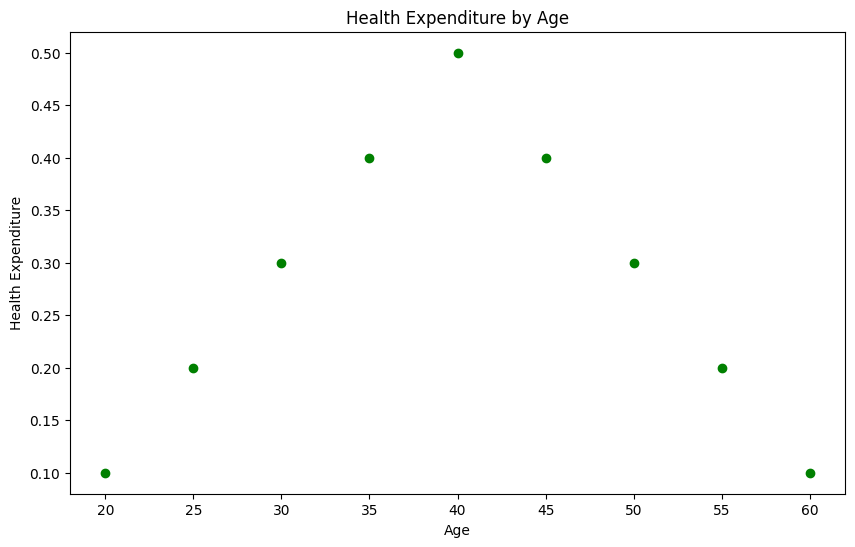

Evaluating:  78%|███████▊  | 39/50 [12:23<02:59, 16.33s/it]

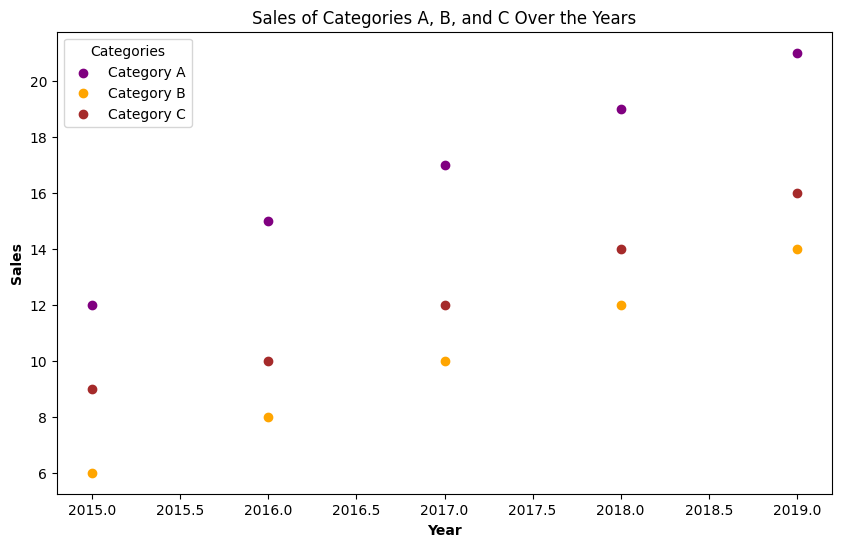

Evaluating:  88%|████████▊ | 44/50 [13:35<01:25, 14.25s/it]

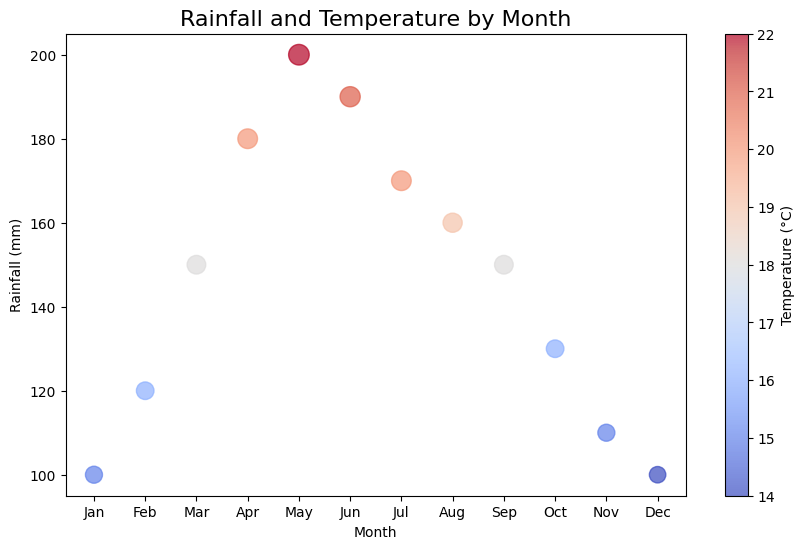

Evaluating:  96%|█████████▌| 48/50 [15:28<00:47, 23.87s/it]

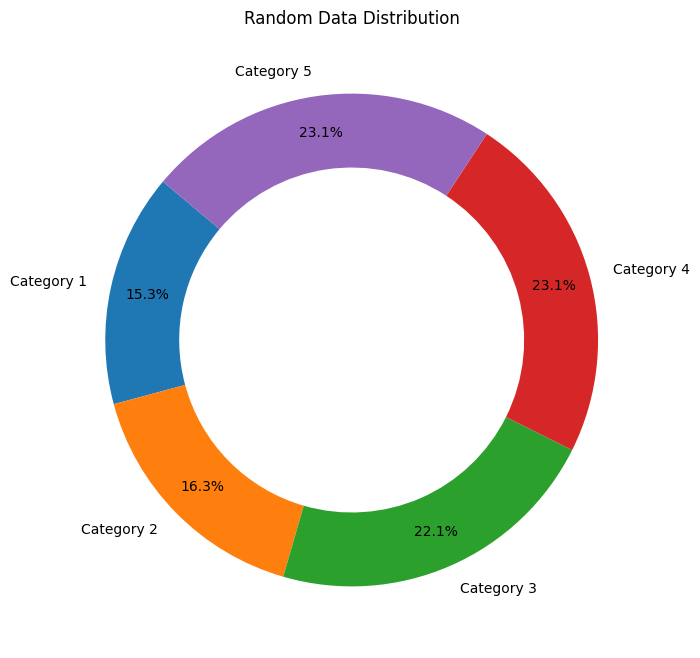

Evaluating:  98%|█████████▊| 49/50 [15:39<00:20, 20.09s/it]

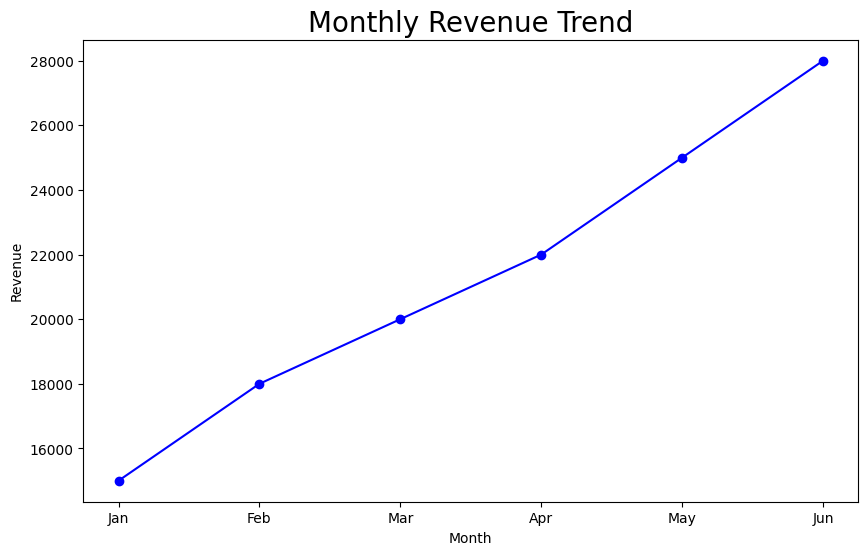

Evaluating: 100%|██████████| 50/50 [15:53<00:00, 19.07s/it]

📊 EVALUATION METRICS

✓ CORE METRICS:
  Syntax Valid:      0.0%
  Compiles:          0.0%
  Executes:          0.0%

📈 CHART ELEMENTS:
  Has Plot:          44.0%
  Has Labels:        75.0%
  Has Title:         84.0%

⭐ OVERALL SCORE: 8.8%
   Samples: 50
   Failed: 50

📋 SAMPLE FAILURES (first 3):

  1. Sample 0:
     Error: unterminated string literal (detected at line 37) (<string>, line 37)
     Code: ```python
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Rea...

  2. Sample 1:
     Error: invalid syntax (<string>, line 1)
     Code: ```python
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(5)
width = 0.35

fig, ax...

  3. Sample 2:
     Error: invalid syntax (<string>, line 1)
     Code: ```python
# Create the box plot
plt.boxplot(data)

# Add the title
plt.title('Distribution of Times'...


In [ ]:
# EVALUATE BASE MODEL

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig
import torch

BASE_MODEL_NAME = "bigcode/starcoderbase-1b"

# 8-bit config
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.float16,
    bnb_8bit_use_double_quant=True,
)

print(f"Loading base model: {BASE_MODEL_NAME} in 8-bit...")
tokenizer_base = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
tokenizer_base.pad_token = tokenizer_base.eos_token
tokenizer_base.padding_side = "right"

model_base = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_NAME,
    device_map="auto",
    quantization_config=bnb_config
)

print("✓ Base model loaded successfully\n")

# Run evaluation with FIXED function

print("EVALUATING BASE MODEL (Before Fine-tuning)")

metrics_base, failed_samples_base = evaluate_without_visualization_fixed(
    model=model_base,
    tokenizer=tokenizer_base,
    dataset_cache_dir="/content/drive/MyDrive/ChartGen_Clean_Dataset",
    num_samples_eval=50,           # How many to evaluate
    num_samples_dataset=2000,      # ← CRITICAL: Must match training!
    max_new_tokens=512,
    compare_with_ground_truth=True
)

print_simple_report(metrics_base, failed_samples_base)

**View Predictions of Base Model**

In [ ]:
evaluate_model_samples_full(model_base, tokenizer_base, eval_dataset_clean, num_samples=2)

FULL SAMPLE PREDICTIONS (NO TRUNCATION)
SAMPLE 52

PREDICTION (length: 369 chars):
```python
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Create a list of tuples
sports = [('Cricket', 280), ('Football', 320), ('Basketball', 250), ('Tennis', 180), ('Hockey', 220)]

# Create a list of colors
colors = ['r', 'g', 'b', 'c', 'm']

# Create a list of bars
bars = [280, 320, 250, 180, 220]

# Create a list of labels


**EVALUATION RESULTS COMPARISON**

**Fine-Tuned Model**

CORE METRICS:
- Syntax Valid:      98.0%
- Compiles:          98.0%
- Executes:          94.0%

CHART ELEMENTS:
- Has Plot:          88.0%
- Has Labels:        76.0%
- Has Title:         100.0%

OVERALL SCORE: 65.0%
- Samples: 50
- Failed: 3

**Base Model**

CORE METRICS:
- Syntax Valid:      0.0%
- Compiles:          0.0%
- Executes:          0.0%

CHART ELEMENTS:
- Has Plot:          44.0%
- Has Labels:        75.0%
- Has Title:         84.0%

OVERALL SCORE: 8.8%
- Samples: 50
- Failed: 50

# **8. Saves Outputs for Both Models**
- Evaluation results
- Summary file


**Save fine-tuned model**

In [ ]:
# Save model & metrics
trainer.save_model()
tokenizer.save_pretrained(OUTPUT_DIR)

('./starcoder2-chartgen-lora/tokenizer_config.json',
 './starcoder2-chartgen-lora/special_tokens_map.json',
 './starcoder2-chartgen-lora/vocab.json',
 './starcoder2-chartgen-lora/merges.txt',
 './starcoder2-chartgen-lora/added_tokens.json',
 './starcoder2-chartgen-lora/tokenizer.json')

In [ ]:
# Copy to Drive
import shutil
import os
from google.colab import drive

SOURCE = "./starcoder2-chartgen-lora"
DESTINATION = "/content/drive/MyDrive/starcoder2-chartgen-lora"

print(f"Copying model to Google Drive...")
print(f"From: {SOURCE}")
print(f"To:   {DESTINATION}")

if os.path.exists(SOURCE):
    shutil.copytree(SOURCE, DESTINATION, dirs_exist_ok=True)
    print("\n✅ MODEL SAFELY COPIED TO GOOGLE DRIVE!")

    # Verify
    if os.path.exists(f"{DESTINATION}/adapter_model.safetensors"):
        size = os.path.getsize(f"{DESTINATION}/adapter_model.safetensors") / 1024**2
        print(f"✓ Adapter: {size:.1f} MB")

    # Copy checkpoints too
    checkpoints = [d for d in os.listdir(SOURCE) if d.startswith('checkpoint-')]
    print(f"✓ Checkpoints copied: {checkpoints}")
else:
    print("⚠️ Source not found yet - training hasn't saved yet")

Copying model to Google Drive...
From: ./starcoder2-chartgen-lora
To:   /content/drive/MyDrive/starcoder2-chartgen-lora

✅ MODEL SAFELY COPIED TO GOOGLE DRIVE!
✓ Adapter: 42.4 MB
✓ Checkpoints copied: ['checkpoint-600', 'checkpoint-675', 'checkpoint-400']


**Save metrics for fine-tuned model**

In [ ]:
import json
import os
from datetime import datetime

# SAVE EVALUATION RESULTS TO GOOGLE DRIVE

# Define Drive path (not OUTPUT_DIR which is in cache)
DRIVE_MODEL_DIR = "/content/drive/MyDrive/starcoder2-chartgen-lora"
RESULTS_DIR = "/content/drive/MyDrive/starcoder2-chartgen-lora/evaluation_results"

# Create results directory if it doesn't exist
os.makedirs(RESULTS_DIR, exist_ok=True)

# Prepare results dictionary
evaluation_results = {
    "model_name": "starcoder2-chartgen-lora",
    "base_model": "bigcode/starcoderbase-1b",
    "evaluation_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "evaluation_config": {
        "num_samples": 50,
        "max_new_tokens": 512,
        "temperature": 0.3,
        "top_p": 0.9,
        "stopping_criteria": "enabled",
    },
    "metrics": {
        "syntax_valid": float(metrics.get('syntax_correctness', 0)),
        "compiles": float(metrics.get('compilation_success', 0)),
        "executes": float(metrics.get('execution_success', 0)),
        "ssim": float(metrics.get('image_ssim', 0)),
        "pixel_similarity": float(metrics.get('pixel_similarity', 0)),
        "has_plot_call": float(metrics.get('has_plot_call', 0)),
        "has_xlabel": float(metrics.get('has_xlabel', 0)),
        "has_ylabel": float(metrics.get('has_ylabel', 0)),
        "has_title": float(metrics.get('has_title', 0)),
        "has_legend": float(metrics.get('has_legend', 0)),
        "has_grid": float(metrics.get('has_grid', 0)),
    },
    "summary": {
        "samples_evaluated": int(metrics['samples_evaluated']),
        "num_failed": int(metrics['num_failed']),
        "overall_score": float(
            metrics.get('execution_success', 0) * 0.40 +
            metrics.get('image_ssim', 0) * 0.30 +
            metrics.get('has_plot_call', 0) * 0.20 +
            metrics.get('syntax_correctness', 0) * 0.10
        ),
    },
    "failed_samples": [
        {
            "idx": f.get('idx'),
            "error": f.get('error'),
            "code_preview": f.get('code', '')[:200]
        }
        for f in failed[:5]  # Save first 5 failures
    ]
}

# Save to Google Drive
output_file = os.path.join(RESULTS_DIR, "final_metrics.json")
with open(output_file, "w") as f:
    json.dump(evaluation_results, f, indent=2)

print("✅ EVALUATION RESULTS SAVED TO GOOGLE DRIVE")
print(f"Location: {output_file}")
print(f"Overall Score: {evaluation_results['summary']['overall_score']:.1%}")
print(f"Execution Success: {evaluation_results['metrics']['executes']:.1%}")

# Also save a human-readable summary
summary_file = os.path.join(RESULTS_DIR, "evaluation_summary.txt")
with open(summary_file, "w") as f:
    f.write("EVALUATION SUMMARY\n")
    f.write(f"Model: {evaluation_results['model_name']}\n")
    f.write(f"Date: {evaluation_results['evaluation_date']}\n")
    f.write(f"Samples: {evaluation_results['summary']['samples_evaluated']}\n\n")

    f.write("CORE METRICS:\n")
    f.write(f"  Syntax Valid:      {evaluation_results['metrics']['syntax_valid']:.1%}\n")
    f.write(f"  Compiles:          {evaluation_results['metrics']['compiles']:.1%}\n")
    f.write(f"  Executes:          {evaluation_results['metrics']['executes']:.1%}\n\n")

    f.write("IMAGE QUALITY:\n")
    f.write(f"  SSIM:              {evaluation_results['metrics']['ssim']:.3f}\n")
    f.write(f"  Pixel Similarity:  {evaluation_results['metrics']['pixel_similarity']:.1%}\n\n")

    f.write("CHART ELEMENTS:\n")
    f.write(f"  Has Plot:          {evaluation_results['metrics']['has_plot_call']:.1%}\n")
    f.write(f"  Has Labels:        {(evaluation_results['metrics']['has_xlabel'] + evaluation_results['metrics']['has_ylabel'])/2:.1%}\n")
    f.write(f"  Has Title:         {evaluation_results['metrics']['has_title']:.1%}\n\n")

    f.write(f"OVERALL SCORE: {evaluation_results['summary']['overall_score']:.1%}\n")
    f.write(f"Failed Samples: {evaluation_results['summary']['num_failed']}\n")

print(f"✓ Summary also saved to: {summary_file}")

✅ EVALUATION RESULTS SAVED TO GOOGLE DRIVE
Location: /content/drive/MyDrive/starcoder2-chartgen-lora/evaluation_results/final_metrics.json
Overall Score: 89.4%
Execution Success: 96.0%
✓ Summary also saved to: /content/drive/MyDrive/starcoder2-chartgen-lora/evaluation_results/evaluation_summary.txt


**Save base model and its metrics**

In [ ]:
import json
import os
from datetime import datetime

# SAVE EVALUATION RESULTS TO GOOGLE DRIVE

# Define Drive path (not OUTPUT_DIR which is in cache)
DRIVE_MODEL_DIR = "/content/drive/MyDrive/starcoder2-chartgen-lora"
RESULTS_DIR = "/content/drive/MyDrive/starcoder2-chartgen-lora/evaluation_results"

# Create results directory if it doesn't exist
os.makedirs(RESULTS_DIR, exist_ok=True)

# Prepare results dictionary
evaluation_results = {
    "model_name": "starcoder2-chartgen-lora",
    "base_model": "bigcode/starcoderbase-1b",
    "evaluation_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "evaluation_config": {
        "num_samples": 50,
        "max_new_tokens": 512,
        "temperature": 0.3,
        "top_p": 0.9,
        "stopping_criteria": "enabled",
    },
    "metrics": {
        "syntax_valid": float(metrics.get('syntax_correctness', 0)),
        "compiles": float(metrics.get('compilation_success', 0)),
        "executes": float(metrics.get('execution_success', 0)),
        "ssim": float(metrics.get('image_ssim', 0)),
        "pixel_similarity": float(metrics.get('pixel_similarity', 0)),
        "has_plot_call": float(metrics.get('has_plot_call', 0)),
        "has_xlabel": float(metrics.get('has_xlabel', 0)),
        "has_ylabel": float(metrics.get('has_ylabel', 0)),
        "has_title": float(metrics.get('has_title', 0)),
        "has_legend": float(metrics.get('has_legend', 0)),
        "has_grid": float(metrics.get('has_grid', 0)),
    },
    "summary": {
        "samples_evaluated": int(metrics['samples_evaluated']),
        "num_failed": int(metrics['num_failed']),
        "overall_score": float(
            metrics.get('execution_success', 0) * 0.40 +
            metrics.get('image_ssim', 0) * 0.30 +
            metrics.get('has_plot_call', 0) * 0.20 +
            metrics.get('syntax_correctness', 0) * 0.10
        ),
    },
    "failed_samples": [
        {
            "idx": f.get('idx'),
            "error": f.get('error'),
            "code_preview": f.get('code', '')[:200]
        }
        for f in failed_samples[:5]  # Save first 5 failures
    ]
}

# Save to Google Drive
output_file = os.path.join(RESULTS_DIR, "final_metrics_base_model.json")
with open(output_file, "w") as f:
    json.dump(evaluation_results, f, indent=2)

print("✅ EVALUATION RESULTS SAVED TO GOOGLE DRIVE")
print(f"Location: {output_file}")
print(f"Overall Score: {evaluation_results['summary']['overall_score']:.1%}")
print(f"Execution Success: {evaluation_results['metrics']['executes']:.1%}")

# Also save a human-readable summary
summary_file = os.path.join(RESULTS_DIR, "evaluation_summary_base_model.txt")
with open(summary_file, "w") as f:
    f.write("EVALUATION SUMMARY\n")
    f.write(f"Model: {evaluation_results['model_name']}\n")
    f.write(f"Date: {evaluation_results['evaluation_date']}\n")
    f.write(f"Samples: {evaluation_results['summary']['samples_evaluated']}\n\n")

    f.write("CORE METRICS:\n")
    f.write(f"  Syntax Valid:      {evaluation_results['metrics']['syntax_valid']:.1%}\n")
    f.write(f"  Compiles:          {evaluation_results['metrics']['compiles']:.1%}\n")
    f.write(f"  Executes:          {evaluation_results['metrics']['executes']:.1%}\n\n")

    f.write("IMAGE QUALITY:\n")
    f.write(f"  SSIM:              {evaluation_results['metrics']['ssim']:.3f}\n")
    f.write(f"  Pixel Similarity:  {evaluation_results['metrics']['pixel_similarity']:.1%}\n\n")

    f.write("CHART ELEMENTS:\n")
    f.write(f"  Has Plot:          {evaluation_results['metrics']['has_plot_call']:.1%}\n")
    f.write(f"  Has Labels:        {(evaluation_results['metrics']['has_xlabel'] + evaluation_results['metrics']['has_ylabel'])/2:.1%}\n")
    f.write(f"  Has Title:         {evaluation_results['metrics']['has_title']:.1%}\n\n")

    f.write(f"OVERALL SCORE: {evaluation_results['summary']['overall_score']:.1%}\n")
    f.write(f"Failed Samples: {evaluation_results['summary']['num_failed']}\n")

print(f"✓ Summary also saved to: {summary_file}")

✅ EVALUATION RESULTS SAVED TO GOOGLE DRIVE
Location: /content/drive/MyDrive/starcoder2-chartgen-lora/evaluation_results/final_metrics_base_model.json
Overall Score: 11.2%
Execution Success: 0.0%
✓ Summary also saved to: /content/drive/MyDrive/starcoder2-chartgen-lora/evaluation_results/evaluation_summary_base_model.txt


## **9. (Optional) Appendix**
- Provides code for cleaning the GPU RAM
- Provides code for uploading the final model to HuggingFace

In [ ]:
import gc
import torch
from numba import cuda

# 1. Delete ALL possible variables
variables_to_delete = ['model', 'trainer', 'train_dataset', 'eval_dataset',
                       'train_dataset_clean', 'eval_dataset_clean',
                       'data_collator', 'training_args', 'lora_config',
                       'outputs', 'inputs', 'batch']

for var in variables_to_delete:
    try:
        if var in globals():
            del globals()[var]
            print(f"✓ Deleted {var}")
    except:
        pass

# 2. Force garbage collection multiple times
for _ in range(3):
    gc.collect()

# 3. Clear CUDA cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

# 4. Try numba cuda clear (if available)
try:
    cuda.select_device(0)
    cuda.close()
except:
    pass

# 5. Check memory again
print("GPU Memory After Aggressive Clear:")
free, total = torch.cuda.mem_get_info()
print(f"Free: {free/1024**3:.2f} GiB / {total/1024**3:.2f} GiB")
print(f"Used: {(total-free)/1024**3:.2f} GiB")

**Uploading final model to HF**

In [ ]:
from dotenv import load_dotenv
import os

# Set path to your .env file in Drive
env_path_two = "/content/drive/MyDrive/Colab Notebooks/upload_model_token.env"

load_dotenv(env_path_two)  # Loads variables from your .env file

# Access your Hugging Face token stored in .env as HF_HUB_TOKEN
hf_write_token = os.getenv("HF_WRITE_TOKEN")

#print("Hugging Face Token:", hf_write_token)  # For debug, remove in production

In [ ]:
from huggingface_hub import login
login(hf_write_token)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from google.colab import drive
from huggingface_hub import login

# 1. Mount Google Drive
drive.mount('/content/drive')

# 3. Set device for inference and upload
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Load the base model and tokenizer
base_model_name = "bigcode/starcoderbase-1b"
model = AutoModelForCausalLM.from_pretrained(base_model_name, torch_dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# 5. Load LoRA adapters from your checkpoint on Drive
lora_path = "/content/drive/MyDrive/starcoder2-chartgen-lora"
model = PeftModel.from_pretrained(model, lora_path)
model.to(device)
model.eval()

# 6. Merge LoRA weights into base model for easier deployment
model = model.merge_and_unload().to(device)

# 7. Define your Hugging Face repo name
repo_name = "dormosol/starcoderbase-chartgen-lora"  # Replace with your HF username and desired repo

# 8. Upload merged model to Hugging Face Hub
print(f"Uploading merged model to https://huggingface.co/{repo_name} ...")
model.push_to_hub(repo_name, use_auth_token=True)

# 9. Upload tokenizer to Hub
print("Uploading tokenizer...")
tokenizer.push_to_hub(repo_name, use_auth_token=True)

print(f"✓ Successfully uploaded to https://huggingface.co/{repo_name}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/777k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/442k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/532 [00:00<?, ?B/s]

Uploading merged model to https://huggingface.co/dormosol/starcoderbase-chartgen-lora ...


/usr/local/lib/python3.12/dist-packages/transformers/utils/hub.py:917: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...tm0qk3u/model.safetensors:   0%|          |  524kB / 2.27GB            

Uploading tokenizer...


README.md: 0.00B [00:00, ?B/s]

✓ Successfully uploaded to https://huggingface.co/dormosol/starcoderbase-chartgen-lora
